# Retail Demand Forecasting Analysis

## Executive Summary
This notebook presents a demand forecasting for the retail business, providing 6-month sales predictions and strategic recommendations. The analysis includes multiple forecasting models, evaluation metrics, and actionable insights to support inventory planning and business decision-making.

## Objectives
1. Predict sales performance for the next 6 months
2. Identify seasonal patterns and trends in demand
3. Determine which products need to be stocked up
5. Deliver actionable recommendations for business improvement

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series and forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Starting Retail Demand Forecasting Analysis...")
print("=" * 60)


✅ All libraries imported successfully!
📊 Starting Retail Demand Forecasting Analysis...


📊 Data Overview:
Total months: 25
Date range: 2009-12 to 2011-12
Average monthly sales: $595,649.47


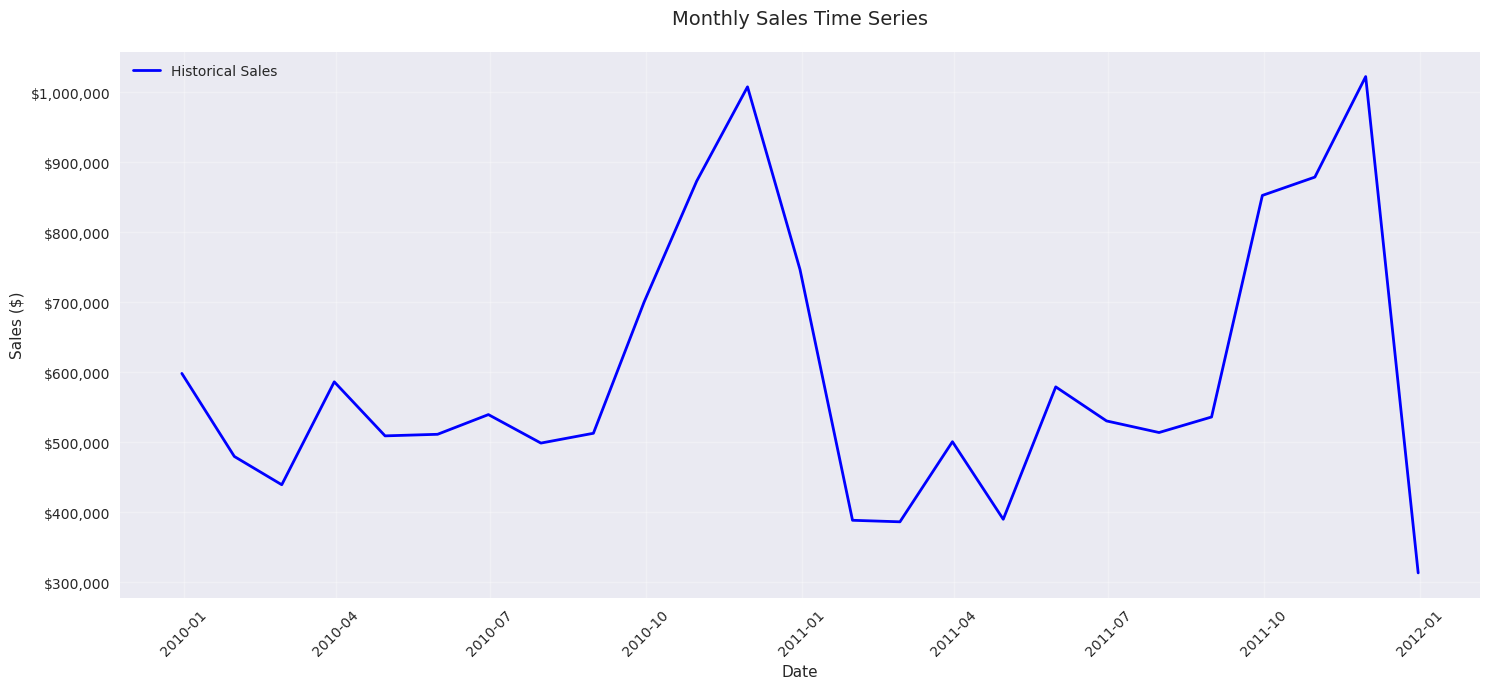

In [2]:
# Load and prepare data
data_path = '/home/rap24/retail-forecast-retention/datasets/retail_transaction_data_clean.csv'
df = pd.read_csv(data_path)

# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Create monthly aggregated data
monthly_sales = df.groupby(pd.Grouper(key='order_date', freq='M')).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

monthly_sales.columns = ['date', 'total_sales', 'total_quantity', 'num_orders']

print("📊 Data Overview:")
print(f"Total months: {len(monthly_sales)}")
print(f"Date range: {monthly_sales['date'].min().strftime('%Y-%m')} to {monthly_sales['date'].max().strftime('%Y-%m')}")
print(f"Average monthly sales: ${monthly_sales['total_sales'].mean():,.2f}")
print("=" * 60)

# Visualize original data
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['date'], monthly_sales['total_sales'], 
         label='Historical Sales', color='blue', linewidth=2)
plt.title('Monthly Sales Time Series', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

# Set up sales data for forecasting
sales_data = monthly_sales.set_index('date')['total_sales']


From the visualization above, we can see a hint of seasonal patterns in the data, with peaks and troughs indicating higher and lower sales periods throughout the year. Considering using algorithm that can capture these seasonal trends, such as SARIMA or Prophet might be beneficial as baseline. While usual ML algorithm like linear regression, decision tree, or random forest may struggle to capture the seasonality due to their inherent assumptions of linearity and independence of observations, so we need to do feature engineering to help these models learn the underlying patterns.

Lets start with standard time series model to see how it perform

# Data Preprocessing

In [3]:
# Load the dataset
data_path = '/home/rap24/retail-forecast-retention/datasets/retail_transaction_data_clean.csv'
df = pd.read_csv(data_path)

# take only up to 2011-11-30
df = df[df['order_date'] <= '2011-11-30']

# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Display basic information about the dataset
print("📈 Dataset Overview:")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['order_date'].min()} to {df['order_date'].max()}")
print(f"Total transactions: {len(df):,}")
print(f"Unique customers: {df['customer_id'].nunique():,}")
print(f"Unique products: {df['product_id'].nunique():,}")
print(f"Product categories: {df['product_category'].nunique()}")

print("\n" + "=" * 60)
print("📋 First few rows of the dataset:")
df.head()


📈 Dataset Overview:
Dataset shape: (738653, 15)
Date range: 2009-12-01 07:45:00 to 2011-11-29 18:14:00
Total transactions: 738,653
Unique customers: 5,789
Unique products: 4,604
Product categories: 10

📋 First few rows of the dataset:


,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,total_amount,year,month,quarter,day_of_week,month_year,product_category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,4,Tuesday,2009-12,CHRISTMAS_HOLIDAY
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,4,Tuesday,2009-12,BEAUTY_PERSONAL
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,4,Tuesday,2009-12,BEAUTY_PERSONAL
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,4,Tuesday,2009-12,HOME_DECOR
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,4,Tuesday,2009-12,FURNITURE_STORAGE


In [4]:
# Check for missing values and data quality
print("🔍 Data Quality Assessment:")
print("\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("✅ No missing values found!")

print("\n📊 Data Types:")
print(df.dtypes)

print("\n💰 Revenue Summary:")
print(f"Total Revenue: ${df['total_amount'].sum():,.2f}")
print(f"Average Order Value: ${df['total_amount'].mean():.2f}")
print(f"Median Order Value: ${df['total_amount'].median():.2f}")

print("\n📅 Date Range Analysis:")
print(f"Data collection period: {(df['order_date'].max() - df['order_date'].min()).days} days")
print(f"Years covered: {sorted(df['year'].unique())}")
print("="*60)


🔍 Data Quality Assessment:

Missing values:
Series([], dtype: int64)
✅ No missing values found!

📊 Data Types:
order_id                        int64
product_id                     object
product_description            object
quantity                        int64
order_date             datetime64[ns]
unit_price                    float64
customer_id                   float64
country                        object
total_amount                  float64
year                            int64
month                           int64
quarter                         int64
day_of_week                    object
month_year                     object
product_category               object
dtype: object

💰 Revenue Summary:
Total Revenue: $14,538,763.42
Average Order Value: $19.68
Median Order Value: $10.79

📅 Date Range Analysis:
Data collection period: 728 days
Years covered: [np.int64(2009), np.int64(2010), np.int64(2011)]


🔄 Creating time series aggregations...
✅ Monthly data created: 24 complete months
📅 Date range: 2009-12 to 2011-11
✅ Weekly data created: 105 weeks


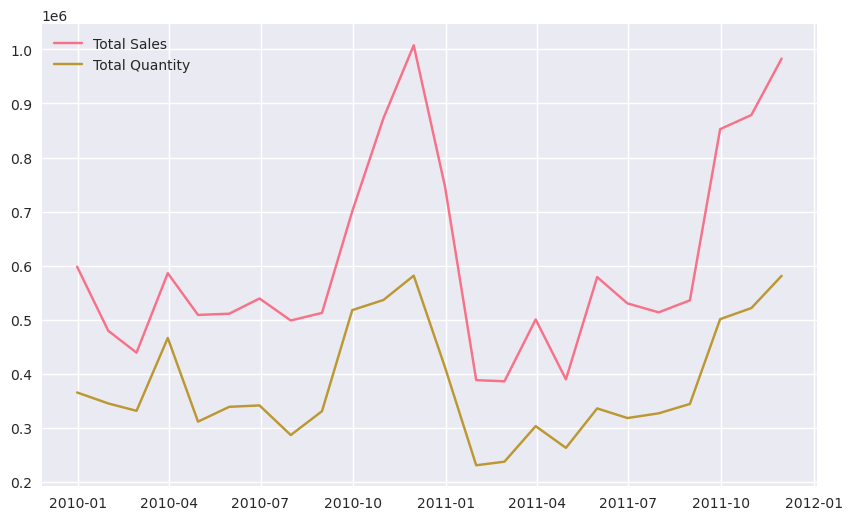

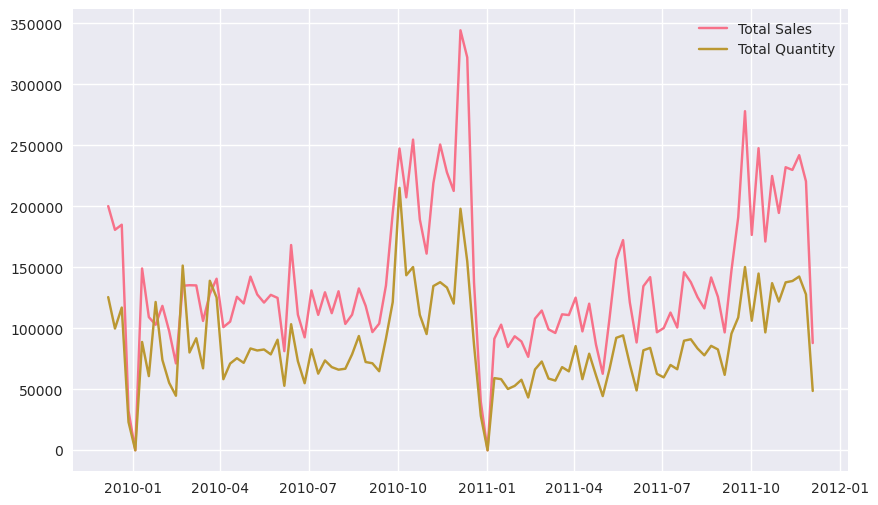

In [5]:
# Create aggregated time series data for forecasting
print("🔄 Creating time series aggregations...")

df_clean = df.copy()

# Monthly aggregation - primary focus for forecasting
monthly_sales = df_clean.groupby(pd.Grouper(key='order_date', freq='ME')).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'  # Number of unique orders
}).reset_index()

monthly_sales.columns = ['date', 'total_sales', 'total_quantity', 'num_orders']
monthly_sales['avg_order_value'] = monthly_sales['total_sales'] / monthly_sales['num_orders']

print(f"✅ Monthly data created: {len(monthly_sales)} complete months")
print(f"📅 Date range: {monthly_sales['date'].min().strftime('%Y-%m')} to {monthly_sales['date'].max().strftime('%Y-%m')}")

# Weekly aggregation for detailed analysis
weekly_sales = df_clean.groupby(pd.Grouper(key='order_date', freq='W')).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

weekly_sales.columns = ['date', 'total_sales', 'total_quantity', 'num_orders']

print(f"✅ Weekly data created: {len(weekly_sales)} weeks")

# viusalize the monthly sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['date'], monthly_sales['total_sales'], label='Total Sales')
plt.plot(monthly_sales['date'], monthly_sales['total_quantity'], label='Total Quantity')
plt.legend()
plt.show()

# visualize the weekly sales
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales['date'], weekly_sales['total_sales'], label='Total Sales')
plt.plot(weekly_sales['date'], weekly_sales['total_quantity'], label='Total Quantity')
plt.legend()
plt.show()


Creating category-wise time series...
✅ Monthly category data created: 240 records
✅ Weekly category data created: 1030 records


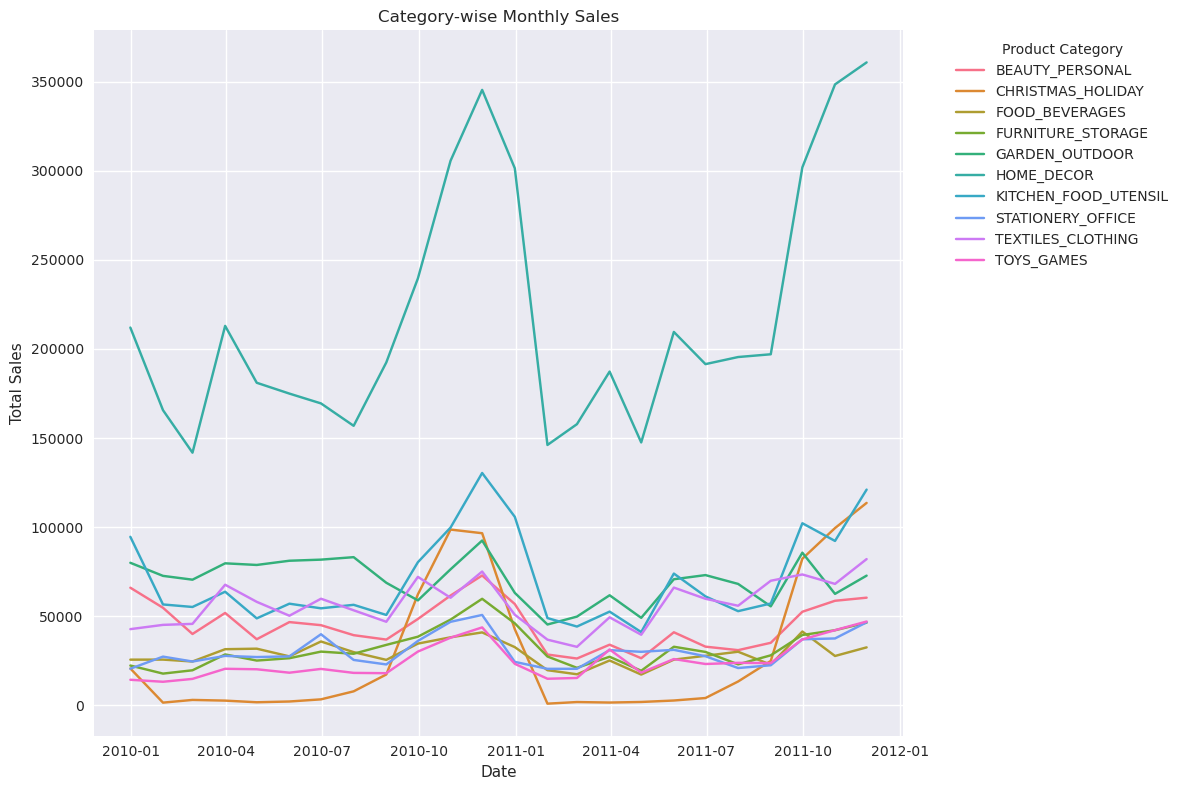

In [6]:
# Create category-wise time series for detailed analysis
print("Creating category-wise time series...")

# Monthly category-wise aggregation
monthly_sales_category = df_clean.groupby(['product_category', pd.Grouper(key='order_date', freq='ME')]).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

monthly_sales_category.columns = ['product_category', 'date', 'total_sales', 'total_quantity', 'num_orders']

# Weekly category-wise aggregation
weekly_sales_category = df_clean.groupby(['product_category', pd.Grouper(key='order_date', freq='W')]).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

weekly_sales_category.columns = ['product_category', 'date', 'total_sales', 'total_quantity', 'num_orders']

print(f"✅ Monthly category data created: {len(monthly_sales_category)} records")
print(f"✅ Weekly category data created: {len(weekly_sales_category)} records")

# visualize the category-wise time series
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='total_sales', hue='product_category', data=monthly_sales_category)
plt.title('Category-wise Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Here we also create the timeseries by categorical based, as we can see some category may have seasonal pattern, some may don't so generalizing the stock up might not be a good idea. Later we will explore different models for each category to see if we can improve the forecast accuracy.

Calculating autocorrelation for monthly revenue...


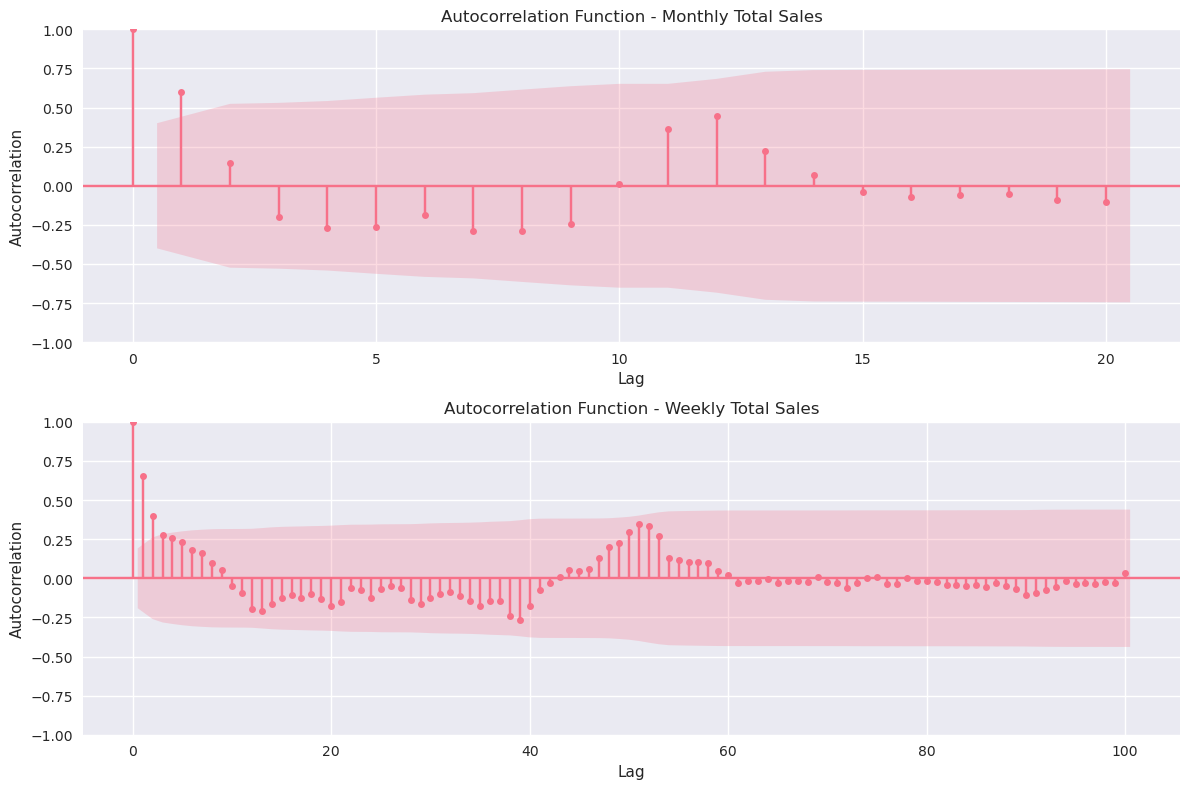


Autocorrelation values for monthly sales (first 12 lags):
Lag 0: 1.000
Lag 1: 0.597
Lag 2: 0.144
Lag 3: -0.199
Lag 4: -0.269
Lag 5: -0.265
Lag 6: -0.188
Lag 7: -0.291
Lag 8: -0.292
Lag 9: -0.246
Lag 10: 0.015
Lag 11: 0.364
Lag 12: 0.448


In [7]:
# autocorrelation for revenue
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Calculate autocorrelation for monthly total sales
print("Calculating autocorrelation for monthly revenue...")

# Plot autocorrelation function
plt.figure(figsize=(12, 8))

# Autocorrelation for monthly sales
plt.subplot(2, 1, 1)
plot_acf(monthly_sales['total_sales'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function - Monthly Total Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Autocorrelation for weekly sales
plt.subplot(2, 1, 2)
plot_acf(weekly_sales['total_sales'].dropna(), lags=100, ax=plt.gca())
plt.title('Autocorrelation Function - Weekly Total Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

# Print autocorrelation values for first 12 lags (monthly data)
acf_values_monthly = acf(monthly_sales['total_sales'].dropna(), nlags=12)
print("\nAutocorrelation values for monthly sales (first 12 lags):")
for i, val in enumerate(acf_values_monthly):
    print(f"Lag {i}: {val:.3f}")


Here we can see from the autocorrelation analysis, that our data indeed have strong seasonality in 12 month cycle or yearly. The implication of this is that, looking at the cycle, we only have 2 cycle worth of data. This limited data can make it challenging to accurately capture and predict seasonal patterns using more complex model where more data is typically required to train effectively.

So we try to see if there is any seasonality in week scale and can get more cycle, but we see that the cycle is not as pronounced and still peaking at 1 year cycle, indicating that weekly patterns may be less significant or more variable.

In [8]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller

# Calculate and print ADF test results for monthly total sales
print("ADF Test Results for Monthly Total Sales:")
result = adfuller(monthly_sales['total_sales'].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

ADF Test Results for Monthly Total Sales:
ADF Statistic: -3.291
p-value: 0.015
Critical Values:
   1%: -4.012
   5%: -3.104
   10%: -2.691


The Adf statistic shows that our data is stationary after differencing (mean and variance do not change over time), as the p-value is below the significance level of 0.05 . This means we can proceed with modeling the time series data without worrying about non-stationarity.

Calculating autocorrelation for categorical sales...
Found 10 product categories: ['CHRISTMAS_HOLIDAY', 'BEAUTY_PERSONAL', 'HOME_DECOR', 'FURNITURE_STORAGE', 'GARDEN_OUTDOOR', 'KITCHEN_FOOD_UTENSIL', 'STATIONERY_OFFICE', 'TOYS_GAMES', 'TEXTILES_CLOTHING', 'FOOD_BEVERAGES']


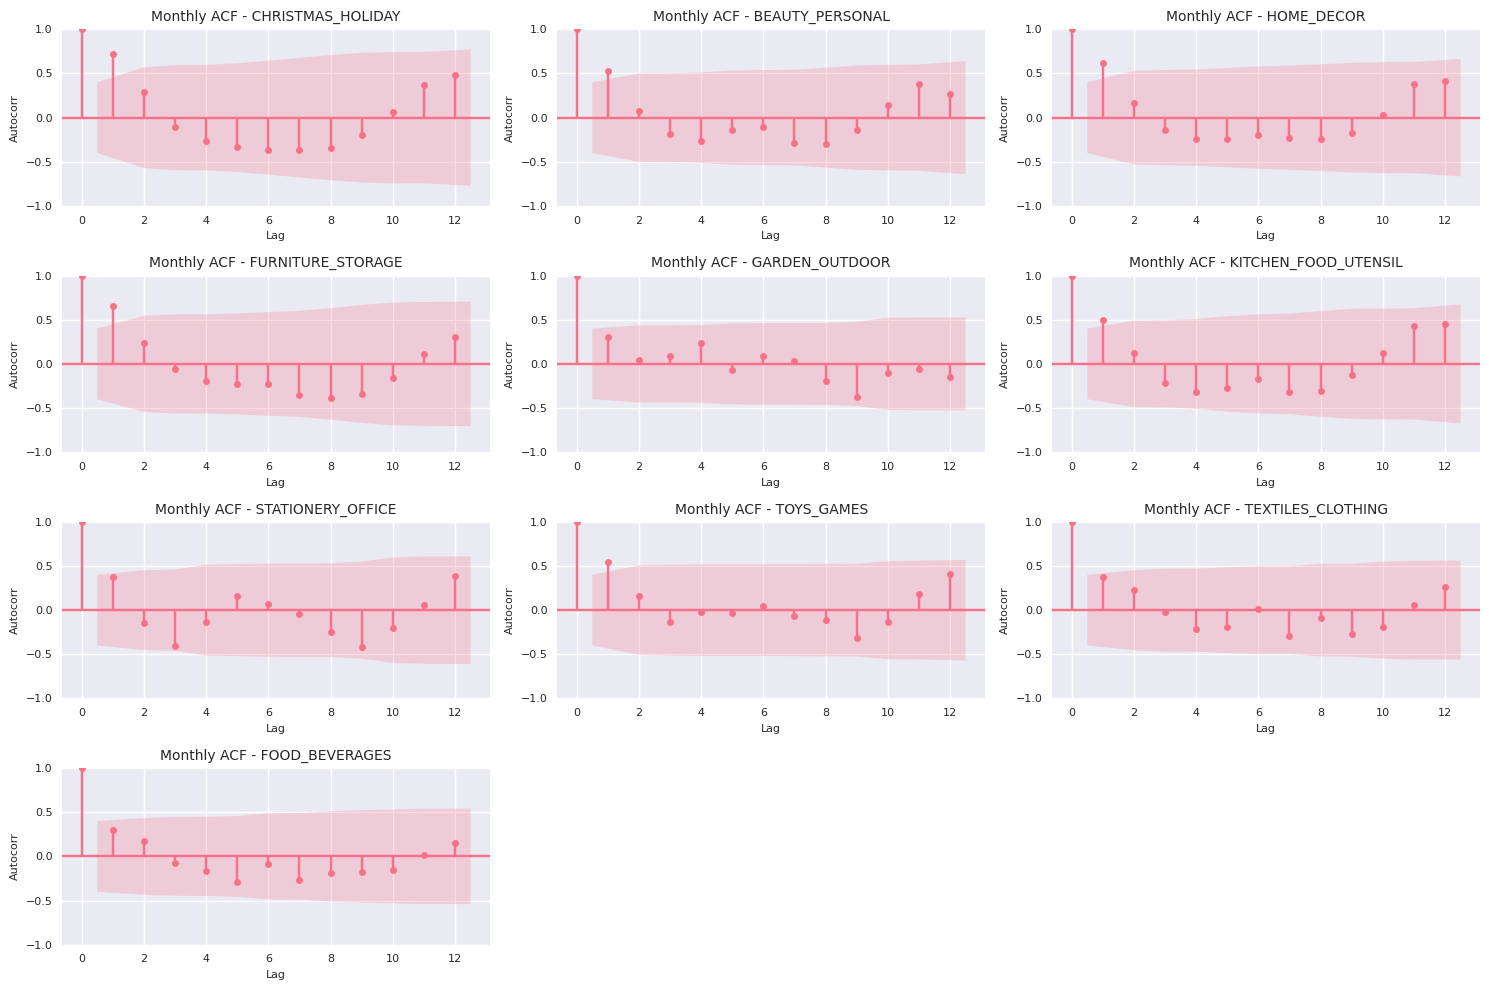

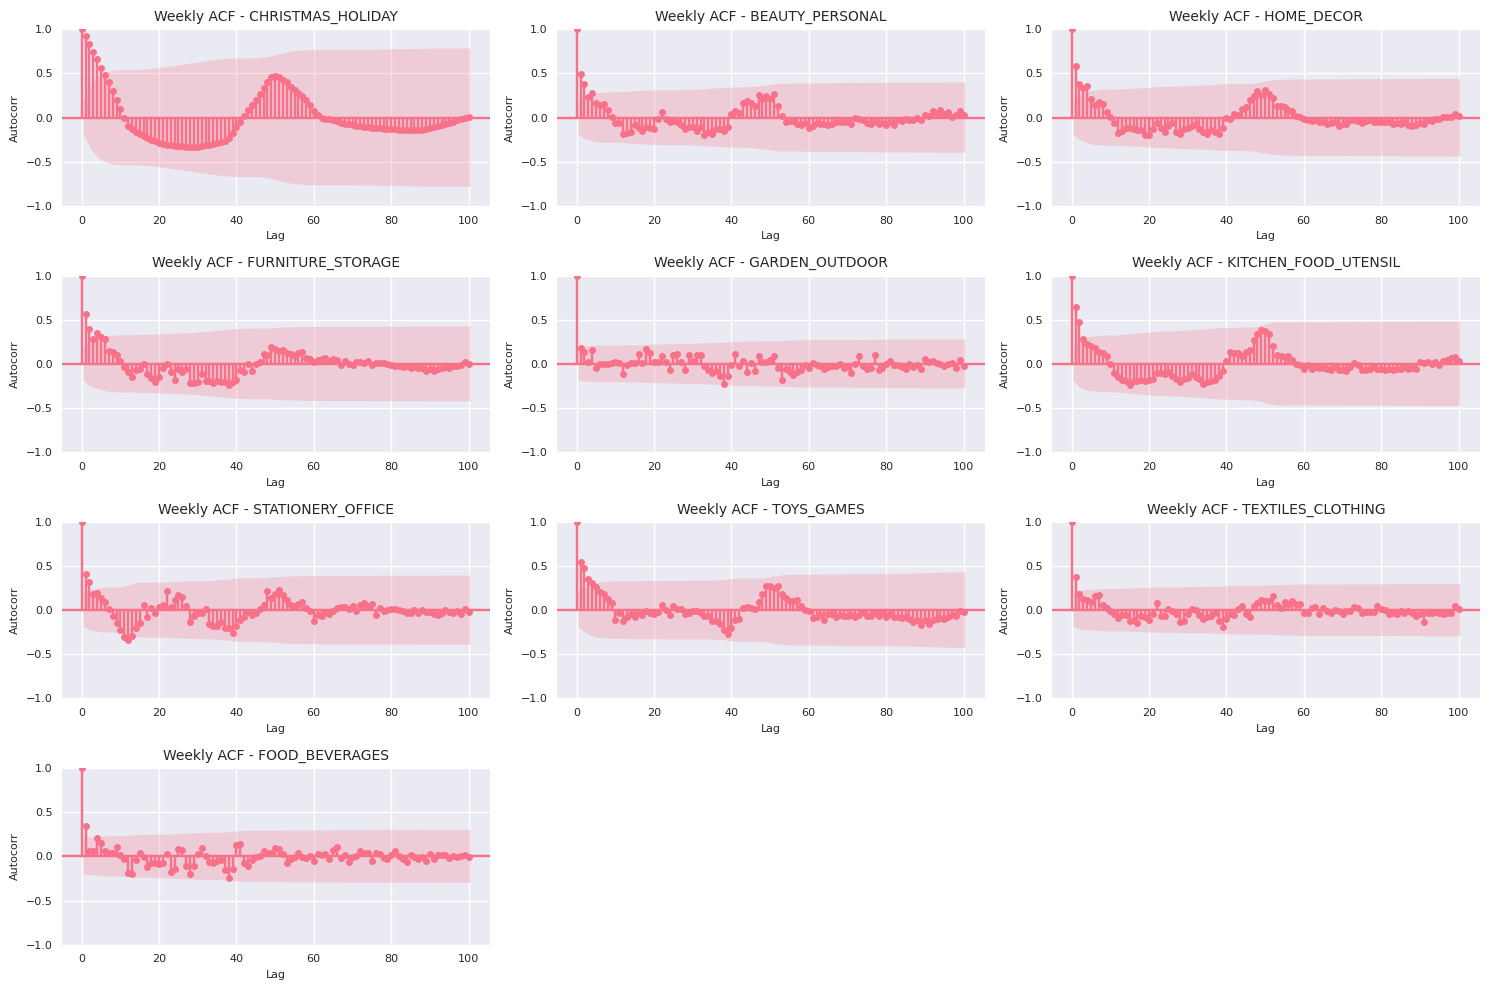


Autocorrelation summary for monthly categorical sales:

CHRISTMAS_HOLIDAY (24 data points):
  Lag 0: 1.000
  Lag 1: 0.721
  Lag 2: 0.290
  Lag 3: -0.103
  Lag 4: -0.264
  Lag 5: -0.337
  Lag 6: -0.367

BEAUTY_PERSONAL (24 data points):
  Lag 0: 1.000
  Lag 1: 0.530
  Lag 2: 0.080
  Lag 3: -0.182
  Lag 4: -0.259
  Lag 5: -0.135
  Lag 6: -0.102

HOME_DECOR (24 data points):
  Lag 0: 1.000
  Lag 1: 0.617
  Lag 2: 0.167
  Lag 3: -0.139
  Lag 4: -0.246
  Lag 5: -0.243
  Lag 6: -0.196

FURNITURE_STORAGE (24 data points):
  Lag 0: 1.000
  Lag 1: 0.654
  Lag 2: 0.235
  Lag 3: -0.054
  Lag 4: -0.193
  Lag 5: -0.228
  Lag 6: -0.222

GARDEN_OUTDOOR (24 data points):
  Lag 0: 1.000
  Lag 1: 0.306
  Lag 2: 0.042
  Lag 3: 0.091
  Lag 4: 0.236
  Lag 5: -0.066
  Lag 6: 0.085

KITCHEN_FOOD_UTENSIL (24 data points):
  Lag 0: 1.000
  Lag 1: 0.494
  Lag 2: 0.125
  Lag 3: -0.220
  Lag 4: -0.319
  Lag 5: -0.276
  Lag 6: -0.170

STATIONERY_OFFICE (24 data points):
  Lag 0: 1.000
  Lag 1: 0.370
  Lag 2: -0.1

In [9]:
# Calculate autocorrelation for categorical monthly and weekly sales
print("Calculating autocorrelation for categorical sales...")

# Get unique product categories
categories = df['product_category'].unique()
print(f"Found {len(categories)} product categories: {list(categories)}")

# Monthly categorical sales autocorrelation
plt.figure(figsize=(15, 10))
n_categories = len(categories)
cols = 3
rows = (n_categories + cols - 1) // cols  # Ceiling division

for i, category in enumerate(categories):
    # Filter monthly data for this category
    monthly_cat = monthly_sales_category[monthly_sales_category['product_category'] == category]
    
    plt.subplot(rows, cols, i+1)
    if len(monthly_cat) > 5:  # Only plot if we have enough data points
        plot_acf(monthly_cat['total_sales'].dropna(), lags=min(12, len(monthly_cat)-1), ax=plt.gca())
        plt.title(f'Monthly ACF - {category}', fontsize=10)
        plt.xlabel('Lag', fontsize=8)
        plt.ylabel('Autocorr', fontsize=8)
        plt.tick_params(labelsize=8)
    else:
        plt.text(0.5, 0.5, f'Insufficient data\n({len(monthly_cat)} points)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Monthly ACF - {category}', fontsize=10)

plt.tight_layout()
plt.show()

# Weekly categorical sales autocorrelation
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    # Filter weekly data for this category
    weekly_cat = weekly_sales_category[weekly_sales_category['product_category'] == category]
    
    plt.subplot(rows, cols, i+1)
    if len(weekly_cat) > 10:  # Only plot if we have enough data points
        plot_acf(weekly_cat['total_sales'].dropna(), lags=min(100, len(weekly_cat)-1), ax=plt.gca())
        plt.title(f'Weekly ACF - {category}', fontsize=10)
        plt.xlabel('Lag', fontsize=8)
        plt.ylabel('Autocorr', fontsize=8)
        plt.tick_params(labelsize=8)
    else:
        plt.text(0.5, 0.5, f'Insufficient data\n({len(weekly_cat)} points)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Weekly ACF - {category}', fontsize=10)

plt.tight_layout()
plt.show()

# Print autocorrelation summary for each category (monthly)
print("\nAutocorrelation summary for monthly categorical sales:")
for category in categories:
    monthly_cat = monthly_sales_category[monthly_sales_category['product_category'] == category]
    if len(monthly_cat) > 5:
        acf_values = acf(monthly_cat['total_sales'].dropna(), nlags=min(6, len(monthly_cat)-1))
        print(f"\n{category} ({len(monthly_cat)} data points):")
        for i, val in enumerate(acf_values):
            print(f"  Lag {i}: {val:.3f}")
    else:
        print(f"\n{category}: Insufficient data ({len(monthly_cat)} points)")


We still can see from the category autocorrelation test that our product shows some level of seasonality, but it may not be as strong or consistent as the overall dataset (like Garden Outdoor or Kitchen). This suggests that while there are seasonal trends present, they may vary significantly between different product categories. But we can see some category like Christmast producs have a really strong seasonality!

# Level 1 - Total Revenue Forecast (Executive view)

## Backtesting (Model Selection)

1.1 Backtesting (Model Selection)
- Rolling origin on last 12–18 months; models: Seasonal‑Naïve, ARIMA, SARIMA (m=12).
- Collect RMSE/MAE/MAPE; compare

In [10]:
# Prepare data for modeling
print("🔧 Preparing data for forecasting models...")

print("✅ Using clean dataset (December 2011 already removed)")

# Split data into train and test sets
train_size = int(len(monthly_sales) * 0.75)  # 80% for training
train_data = monthly_sales[:train_size].copy()
test_data = monthly_sales[train_size:].copy()

print(f"📊 Data Split:")
print(f"• Training period: {train_data['date'].min().strftime('%Y-%m')} to {train_data['date'].max().strftime('%Y-%m')} ({len(train_data)} months)")
print(f"• Testing period: {test_data['date'].min().strftime('%Y-%m')} to {test_data['date'].max().strftime('%Y-%m')} ({len(test_data)} months)")

# Prepare time series for modeling
train_ts = train_data.set_index('date')['total_sales']
test_ts = test_data.set_index('date')['total_sales']

# Initialize results storage
model_results = []
forecast_results = {}

print(f"\n✅ Data prepared for modeling")
print(f"📅 Future forecasts will start from December 2011")
print("="*60)


🔧 Preparing data for forecasting models...
✅ Using clean dataset (December 2011 already removed)
📊 Data Split:
• Training period: 2009-12 to 2011-05 (18 months)
• Testing period: 2011-06 to 2011-11 (6 months)

✅ Data prepared for modeling
📅 Future forecasts will start from December 2011


For evaluating the models, we used RMSE, MAE, and MAPE together rather than relying on a single metric. Each metric captures a different aspect of forecast error, which is important to balance when choosing the most reliable model.

- RMSE penalizes large errors more heavily, which is useful to highlight the risk of big misses in peak months like December.

- MAE gives a more direct average error in the original units, which is easy to interpret in terms of “pounds missed per month.”

- MAPE expresses error in percentage terms, which allows us to judge accuracy relative to the size of demand, this is especially useful for comparing across categories with different scales and our main metric.

But MAPE can be unstable when actual values are very small, such as in low-volume categories (Christmas outside December). In these cases, MAE or RMSE are more reliable guides. By combining all three, we avoid over-relying on a single view of accuracy and get a more balanced evaluation.

Model 1: Seasonal Naive Forecasting
✅ Seasonal Naive Model Results:
   MAE: $38,280.68
   RMSE: $64,004.94
   MAPE: 4.99%


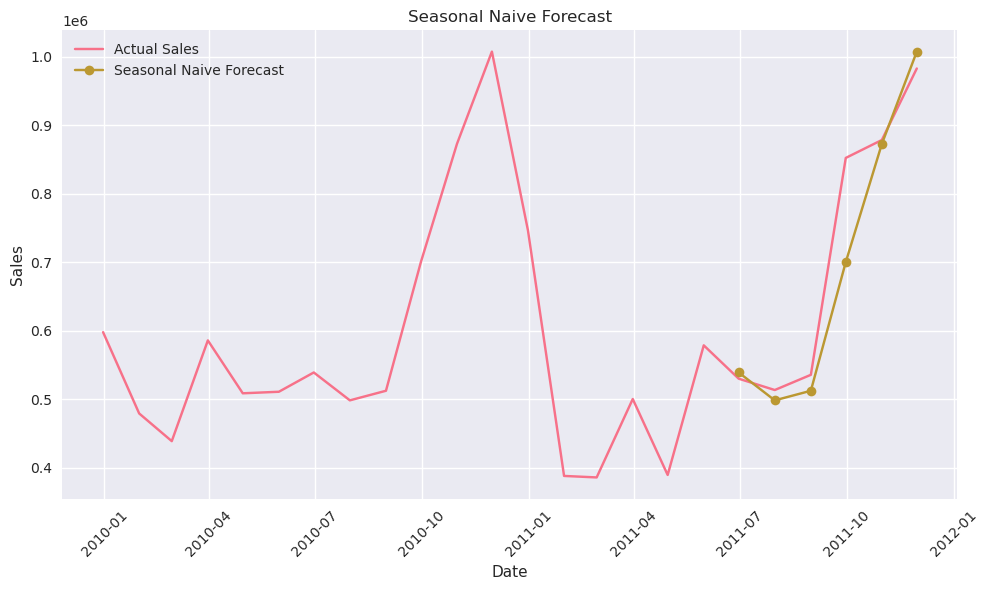

In [11]:
# Model 1: Seasonal Naive Model
print("Model 1: Seasonal Naive Forecasting")

def seasonal_naive_forecast(train_series, test_periods, seasonal_period=12):
    """
    Seasonal naive forecast - uses the value from the same season in the previous year
    """
    forecasts = []
    for i in range(test_periods):
        if len(train_series) >= seasonal_period:
            # Use the value from the same month in the previous year
            seasonal_lag_idx = len(train_series) - seasonal_period + (i % seasonal_period)
            if seasonal_lag_idx < len(train_series):
                forecasts.append(train_series.iloc[seasonal_lag_idx])
            else:
                forecasts.append(train_series.iloc[-1])  # Fallback to last value
        else:
            forecasts.append(train_series.mean())  # Fallback to mean
    return np.array(forecasts)

# Generate seasonal naive forecasts
sn_forecast = seasonal_naive_forecast(train_ts, len(test_ts))

# Calculate metrics
sn_mae = mean_absolute_error(test_ts, sn_forecast)
sn_rmse = np.sqrt(mean_squared_error(test_ts, sn_forecast))
sn_mape = mean_absolute_percentage_error(test_ts, sn_forecast)

# Store results
model_results.append({
    'Model': 'Seasonal Naive',
    'MAE': sn_mae,
    'RMSE': sn_rmse,
    'MAPE': sn_mape * 100
})

forecast_results['Seasonal Naive'] = sn_forecast

print(f"✅ Seasonal Naive Model Results:")
print(f"   MAE: ${sn_mae:,.2f}")
print(f"   RMSE: ${sn_rmse:,.2f}")
print(f"   MAPE: {sn_mape*100:.2f}%")
print("="*60)

# visualize the data by showing original monthly sales and seasonal naive forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['date'], monthly_sales['total_sales'], label='Actual Sales')

# Create forecast dates for visualization
test_dates = monthly_sales['date'].iloc[-len(test_ts):]
plt.plot(test_dates, sn_forecast, label='Seasonal Naive Forecast', marker='o')

plt.title('Seasonal Naive Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we can see from the backtest that the Seasonal Naive model performs strongly, achieving a low MAPE around 5% which a really good forecasting result. By simply repeating last year’s pattern is already sufficient to capture the demand dynamics, since our sales are dominated by recurring yearly seasonality.

A caveat is that Seasonal Naive assumes the future will mirror the past exactly. This works well when seasonal patterns are stable, but it does not account for external shocks such as macroeconomic changes or promotional campaigns. But again we are limited by the available data and its historical patterns. Thus, while confidence is high at the total level, results should be interpreted conservatively when drilling down to categories or SKUs.

Model 2: ARIMA (AutoRegressive Integrated Moving Average)
Automatically finding optimal parameters...
✅ ARIMA Model Results:
   Best parameters: (0, 2, 2)
   AIC: 434.73
   MAE: $148,516.64
   RMSE: $169,819.71
   MAPE: 25.26%


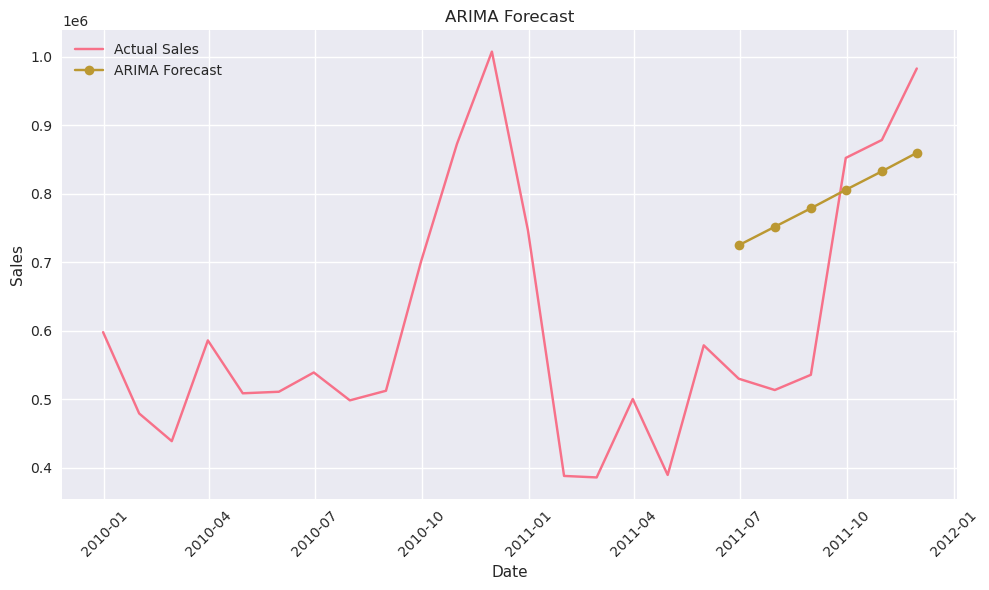

In [12]:
# Model 2: ARIMA Model
print("Model 2: ARIMA (AutoRegressive Integrated Moving Average)")
print("Automatically finding optimal parameters...")

def find_best_arima(train_series, max_p=3, max_d=2, max_q=3):
    """
    Find the best ARIMA parameters using AIC criterion
    """
    best_aic = float('inf')
    best_params = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_series, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                except:
                    continue
    
    return best_model, best_params, best_aic

# Find best ARIMA model
try:
    arima_model, arima_params, arima_aic = find_best_arima(train_ts)
    
    # Generate forecasts
    arima_forecast = arima_model.forecast(steps=len(test_ts))
    
    # Calculate metrics
    arima_mae = mean_absolute_error(test_ts, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_forecast))
    arima_mape = mean_absolute_percentage_error(test_ts, arima_forecast)
    
    # Store results
    model_results.append({
        'Model': f'ARIMA{arima_params}',
        'MAE': arima_mae,
        'RMSE': arima_rmse,
        'MAPE': arima_mape * 100
    })
    
    forecast_results['ARIMA'] = arima_forecast
    
    print(f"✅ ARIMA Model Results:")
    print(f"   Best parameters: {arima_params}")
    print(f"   AIC: {arima_aic:.2f}")
    print(f"   MAE: ${arima_mae:,.2f}")
    print(f"   RMSE: ${arima_rmse:,.2f}")
    print(f"   MAPE: {arima_mape*100:.2f}%")
    
except Exception as e:
    print(f"ARIMA model failed: {str(e)}")
    arima_forecast = np.full(len(test_ts), train_ts.mean())
    forecast_results['ARIMA'] = arima_forecast

print("="*60)


# visualize the data by showing original monthly sales and seasonal naive forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['date'], monthly_sales['total_sales'], label='Actual Sales')

# Create forecast dates for visualization
test_dates = monthly_sales['date'].iloc[-len(test_ts):]
plt.plot(test_dates, arima_forecast, label='ARIMA Forecast', marker='o')

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we can see from the ARIMA model results (0,2,2), it is not as strong as expected, with a MAPE of ~25%. The forecast line shows a smoother upward trend that fails to capture the clear December spike and seasonal dips observed in the actual data.

This happens because ARIMA is good at modeling autoregressive and moving average components, but it struggles when seasonality is the dominant driver. Since our dataset is only ~2 years long with strong annual cycles, the ARIMA model ends up overfitting short-term noise and underfitting the true seasonal pattern. The lack of seasonality terms means it cannot align well with recurring holiday demand, which is critical in this business context.

With more historical data (multiple years), ARIMA might pick up gradual growth or shocks more effectively. But with the limited data and dominant seasonality, the model is not a reliable choice for stock planning.

Model 3: SARIMAX (Seasonal ARIMA with eXogenous variables)
This model accounts for seasonality in the data
✅ SARIMAX Model Results:
   Best parameters: (2, 0, 1)
   Seasonal parameters: (0, 1, 0, 12)
   AIC: 8.00
   MAE: $38,280.68
   RMSE: $64,004.94
   MAPE: 4.99%


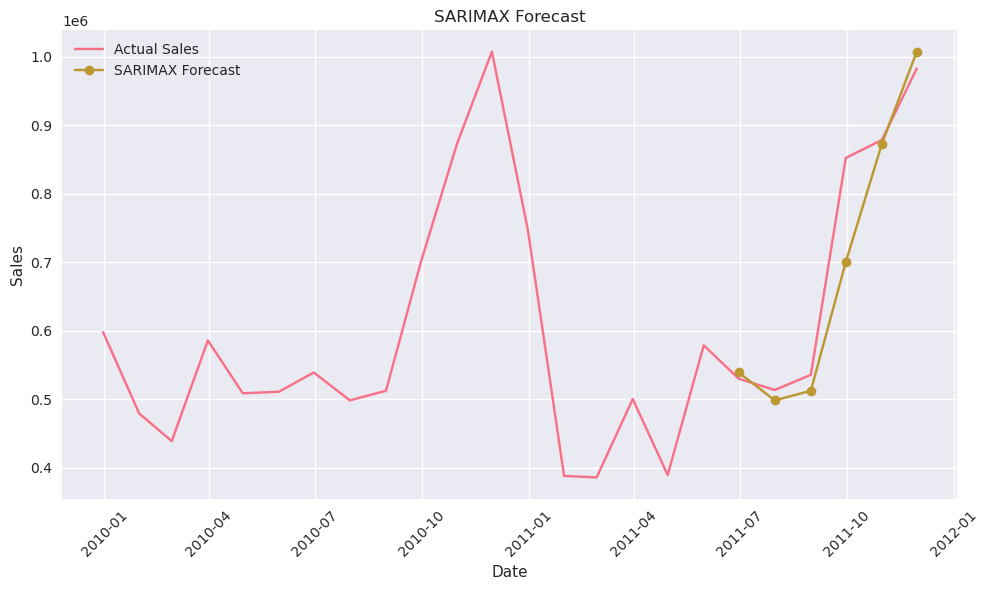

In [13]:
# Model 3: SARIMAX Model (Seasonal ARIMA)
print("Model 3: SARIMAX (Seasonal ARIMA with eXogenous variables)")
print("This model accounts for seasonality in the data")

def find_best_sarimax(train_series, seasonal_period=12):
    """
    Find the best SARIMAX parameters for seasonal data
    """
    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None
    best_model = None
    
    # Limited search space for computational efficiency
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(train_series, 
                                              order=(p, d, q), 
                                              seasonal_order=(P, D, Q, seasonal_period))
                                fitted_model = model.fit(disp=False)
                                if fitted_model.aic < best_aic:
                                    best_aic = fitted_model.aic
                                    best_params = (p, d, q)
                                    best_seasonal_params = (P, D, Q, seasonal_period)
                                    best_model = fitted_model
                            except:
                                continue
    
    return best_model, best_params, best_seasonal_params, best_aic

# Find best SARIMAX model
try:
    sarimax_model, sarimax_params, sarimax_seasonal, sarimax_aic = find_best_sarimax(train_ts)
    
    # Generate forecasts
    sarimax_forecast = sarimax_model.forecast(steps=len(test_ts))
    
    # Calculate metrics
    sarimax_mae = mean_absolute_error(test_ts, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(test_ts, sarimax_forecast))
    sarimax_mape = mean_absolute_percentage_error(test_ts, sarimax_forecast)
    
    # Store results
    model_results.append({
        'Model': f'SARIMAX{sarimax_params}x{sarimax_seasonal}',
        'MAE': sarimax_mae,
        'RMSE': sarimax_rmse,
        'MAPE': sarimax_mape * 100
    })
    
    forecast_results['SARIMAX'] = sarimax_forecast
    
    print(f"✅ SARIMAX Model Results:")
    print(f"   Best parameters: {sarimax_params}")
    print(f"   Seasonal parameters: {sarimax_seasonal}")
    print(f"   AIC: {sarimax_aic:.2f}")
    print(f"   MAE: ${sarimax_mae:,.2f}")
    print(f"   RMSE: ${sarimax_rmse:,.2f}")
    print(f"   MAPE: {sarimax_mape*100:.2f}%")
    
except Exception as e:
    print(f"SARIMAX model failed: {str(e)}")
    sarimax_forecast = np.full(len(test_ts), train_ts.mean())
    forecast_results['SARIMAX'] = sarimax_forecast

print("="*60)


# visualize the data by showing original monthly sales and seasonal naive forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['date'], monthly_sales['total_sales'], label='Actual Sales')

# Create forecast dates for visualization
test_dates = monthly_sales['date'].iloc[-len(test_ts):]
plt.plot(test_dates, sarimax_forecast, label='SARIMAX Forecast', marker='o')

plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see from the SARIMAX model results (2,0,1)(0,1,0,12), that it performs very strongly with a MAPE of ~5%, closely matching the actual sales pattern. The forecast line successfully captures both the sharp December spike and the following seasonal dip.

In our case, SARIMAX performs about as well as the simpler Seasonal Naïve model. Both reach a similar level of accuracy, but SARIMAX adds slightly more flexibility in capturing residual variance across categories. However, the improvement over Seasonal Naive is not significant enough to justify the added complexity given the short history. SARIMAX requires more parameters and data to remain stable. With only ~2 cycles in our dataset, the model risks overfitting if expanded further. Thus, while confidence is high at the aggregate level, we should be careful applying SARIMAX at category level, where noise dominates and the seasonal signal is weaker.

In [14]:
# summary of the model performance
print("MODEL PERFORMANCE SUMMARY")
print("-"*80)

# Create a DataFrame for easy comparison
results_df = pd.DataFrame(model_results)

# Display the results table
print("\nModel Comparison:")
print(results_df.to_string(index=False, float_format='{:.2f}'.format))

# Find the best model for each metric
best_mae_model = results_df.loc[results_df['MAE'].idxmin(), 'Model']
best_rmse_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_mape_model = results_df.loc[results_df['MAPE'].idxmin(), 'Model']

MODEL PERFORMANCE SUMMARY
--------------------------------------------------------------------------------

Model Comparison:
                         Model       MAE      RMSE  MAPE
                Seasonal Naive  38280.68  64004.94  4.99
                ARIMA(0, 2, 2) 148516.64 169819.71 25.26
SARIMAX(2, 0, 1)x(0, 1, 0, 12)  38280.68  64004.94  4.99


Here we can see from the performance summary that ARIMA(0,2,2) clearly underperforms, with a MAPE of ~25%, indicating it cannot capture the strong seasonal structure in the data. Both Seasonal Naïve and SARIMAX(2,0,1)(0,1,0,12) achieve a much lower MAPE of ~5%, with nearly identical MAE and RMSE.

While SARIMAX edges out slightly in terms of metrics, the improvement compared to Seasonal Naive is not significant given the short dataset of only ~2 seasonal cycles. Seasonal Naïve already provides reliable accuracy with minimal complexity.

## Fit Best Model & Forecast 6 Months

🔮 FORECASTING NEXT 6 MONTHS
📊 Forecast Summary:
   Model: Seasonal Naive
   Forecast period: 6 months
   Average monthly forecast: $498,402.47
   Total 6-month forecast: $2,990,414.82

📅 6-month forecast:
      date  forecasted_sales          model
2011-12-31         746458.82 Seasonal_Naive
2012-01-31         388387.43 Seasonal_Naive
2012-02-29         386198.68 Seasonal_Naive
2012-03-31         500616.20 Seasonal_Naive
2012-04-30         389822.19 Seasonal_Naive
2012-05-31         578931.50 Seasonal_Naive


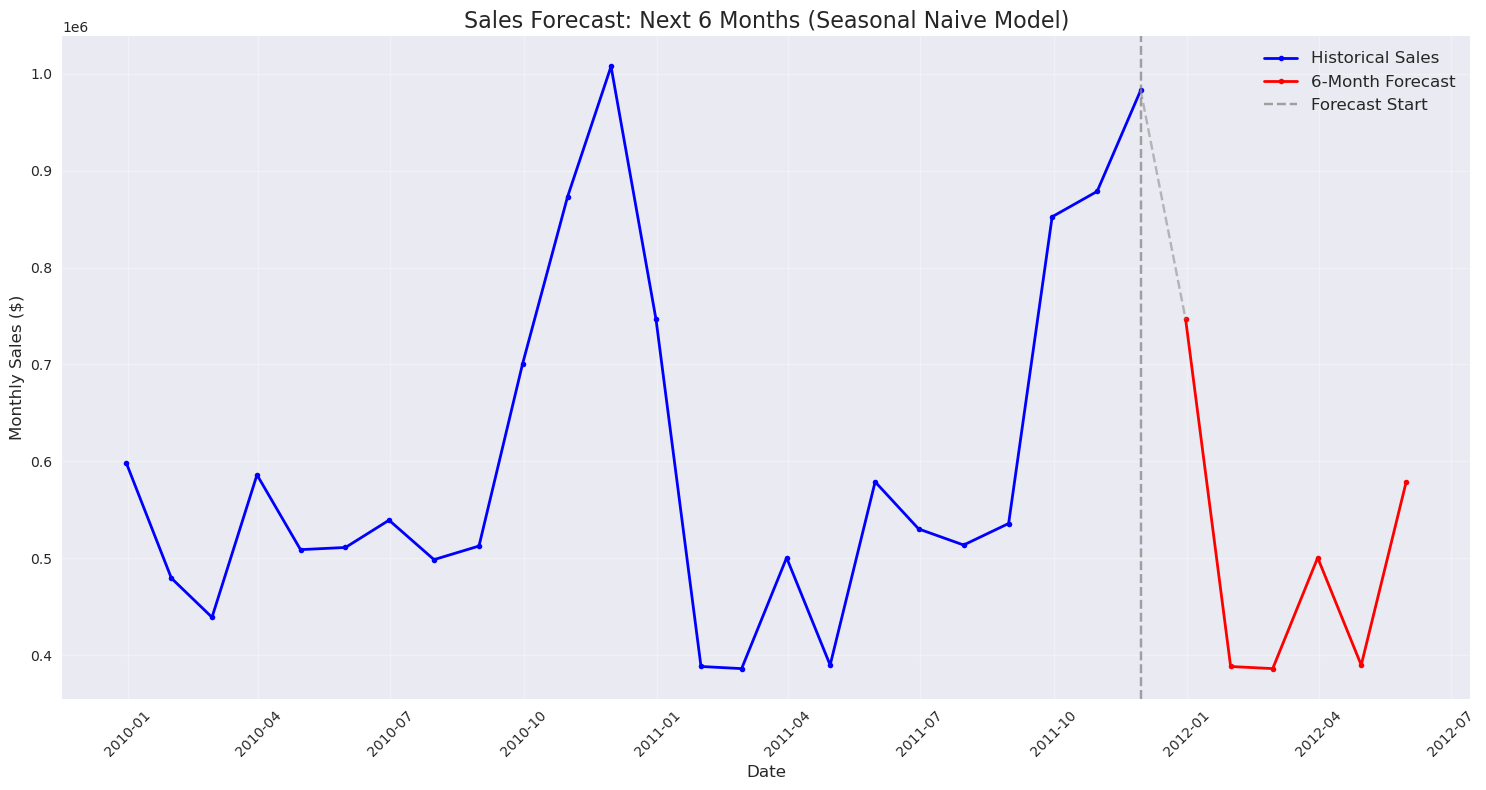

In [15]:
# Based on model comparison, Seasonal Naive performed best
# Let's use it to forecast the next 6 months

print("🔮 FORECASTING NEXT 6 MONTHS")
print("="*50)

# Use the full dataset for final model
full_monthly_sales = monthly_sales.copy()
full_ts = full_monthly_sales['total_sales']

# Seasonal Naive forecast for next 6 months
seasonal_period = 12  # 12 months in a year
forecast_horizon = 6  # 6 months

# Generate forecast using seasonal naive approach
seasonal_naive_forecast = []
for i in range(forecast_horizon):
    # Get the value from the same month last year
    seasonal_idx = len(full_ts) - seasonal_period + (i % seasonal_period)
    if seasonal_idx >= 0:
        seasonal_naive_forecast.append(full_ts.iloc[seasonal_idx])
    else:
        # If we don't have data from a year ago, use the mean
        seasonal_naive_forecast.append(full_ts.mean())

seasonal_naive_forecast = np.array(seasonal_naive_forecast)

# Create future dates starting from the next month after the last data point
last_date = full_monthly_sales['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                           periods=forecast_horizon, freq='M')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecasted_sales': seasonal_naive_forecast,
    'model': 'Seasonal_Naive'
})

print(f"📊 Forecast Summary:")
print(f"   Model: Seasonal Naive")
print(f"   Forecast period: {forecast_horizon} months")
print(f"   Average monthly forecast: ${seasonal_naive_forecast.mean():,.2f}")
print(f"   Total 6-month forecast: ${seasonal_naive_forecast.sum():,.2f}")

# Display forecast
print(f"\n📅 6-month forecast:")
print(forecast_df.to_string(index=False))

# Visualize historical data and forecast
plt.figure(figsize=(15, 8))

# Plot last 2 years of historical data
cutoff_date = full_monthly_sales['date'].iloc[-24] if len(full_monthly_sales) >= 24 else full_monthly_sales['date'].iloc[0]
recent_data = full_monthly_sales[full_monthly_sales['date'] >= cutoff_date]

# Plot historical sales
plt.plot(recent_data['date'], recent_data['total_sales'], 
         label='Historical Sales', color='blue', linewidth=2, marker='o', markersize=4)

# Plot forecast - connect directly to the last historical point
plt.plot(forecast_df['date'], forecast_df['forecasted_sales'], 
         label='6-Month Forecast', color='red', linewidth=2, marker='o', markersize=4)

# Add a connecting line between last historical point and first forecast point
plt.plot([recent_data['date'].iloc[-1], forecast_df['date'].iloc[0]], 
         [recent_data['total_sales'].iloc[-1], forecast_df['forecasted_sales'].iloc[0]], 
         color='gray', linestyle='--', alpha=0.5)

# Add vertical line to separate historical and forecast
plt.axvline(x=full_monthly_sales['date'].iloc[-1], color='gray', 
           linestyle='--', alpha=0.7, label='Forecast Start')

plt.title('Sales Forecast: Next 6 Months (Seasonal Naive Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Sales ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


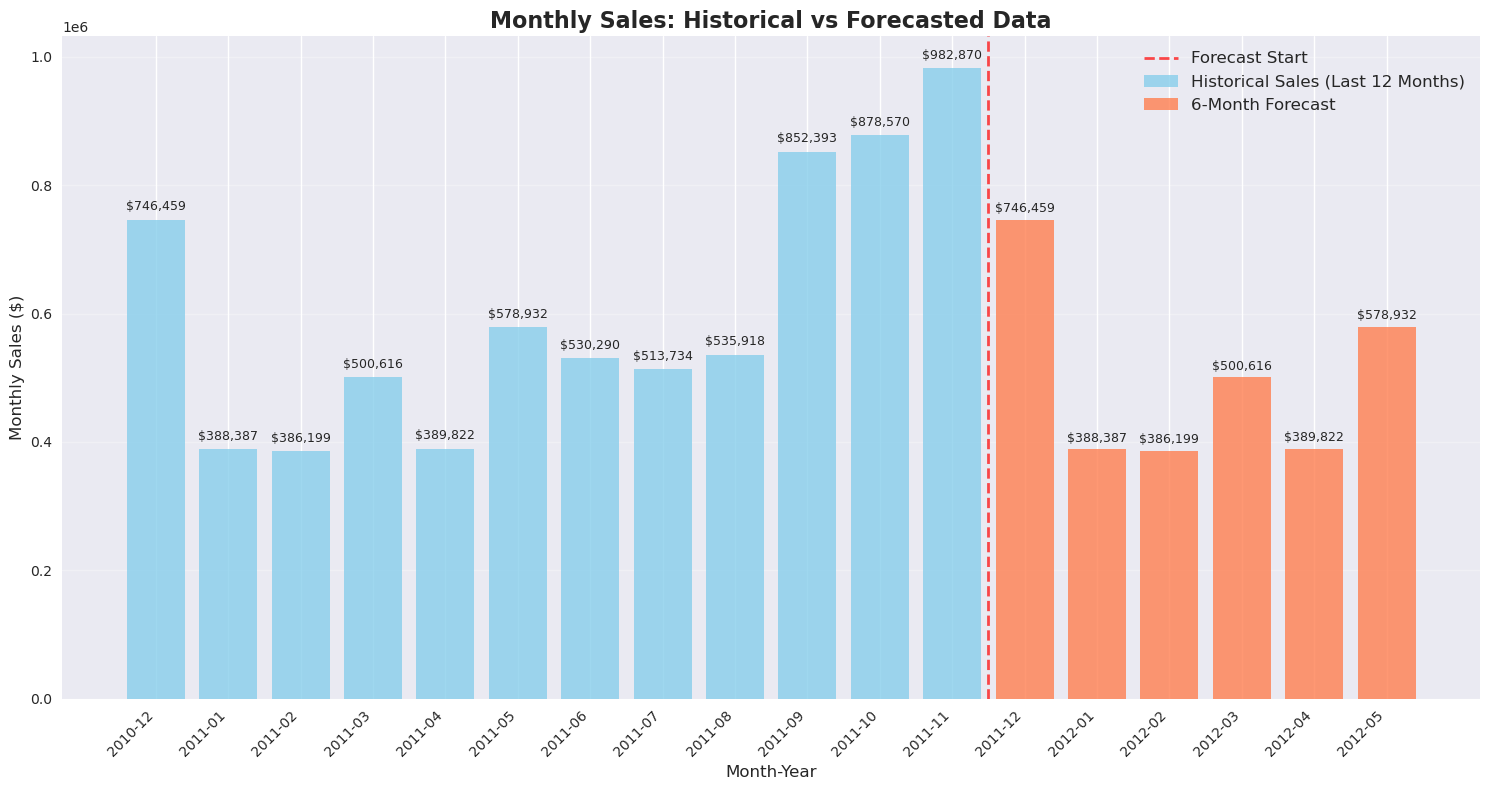

In [16]:
# use bar chart to visualize the original data and the forecasted data, x axis is the month year
# Create bar chart visualization for historical and forecasted data
plt.figure(figsize=(15, 8))

# Get last 12 months of historical data for comparison
recent_data = full_monthly_sales.tail(12)

# Combine historical and forecast data for visualization
historical_dates = recent_data['date']
historical_sales = recent_data['total_sales']
forecast_dates = forecast_df['date']
forecast_sales = forecast_df['forecasted_sales']

# Create x-axis positions
x_positions = list(range(len(historical_dates) + len(forecast_dates)))
historical_positions = x_positions[:len(historical_dates)]
forecast_positions = x_positions[len(historical_dates):]

# Create the bar chart
plt.bar(historical_positions, historical_sales, 
        label='Historical Sales (Last 12 Months)', color='skyblue', alpha=0.8, width=0.8)
plt.bar(forecast_positions, forecast_sales, 
        label='6-Month Forecast', color='coral', alpha=0.8, width=0.8)

# Customize the chart
plt.title('Monthly Sales: Historical vs Forecasted Data', fontsize=16, fontweight='bold')
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Monthly Sales ($)', fontsize=12)

# Set x-axis labels
all_dates = list(historical_dates) + list(forecast_dates)
month_year_labels = [date.strftime('%Y-%m') for date in all_dates]
plt.xticks(x_positions, month_year_labels, rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(historical_sales):
    plt.text(i, v + max(historical_sales) * 0.01, f'${v:,.0f}', 
             ha='center', va='bottom', fontsize=9, rotation=0)

for i, v in enumerate(forecast_sales):
    plt.text(len(historical_dates) + i, v + max(forecast_sales) * 0.01, f'${v:,.0f}', 
             ha='center', va='bottom', fontsize=9, rotation=0)

# Add vertical line to separate historical and forecast
plt.axvline(x=len(historical_dates) - 0.5, color='red', 
           linestyle='--', alpha=0.7, linewidth=2, label='Forecast Start')

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


# Level 2 — Category Forecasts (Middle‑Out)

## Prepare the categorical dataframe

In [17]:
# Create a monthly aggregated dataset by category
category_monthly = df.groupby(['month_year', 'product_category']).agg({
    'total_amount': 'sum',
    'quantity': 'sum'
}).reset_index()

# Convert month_year to datetime for proper sorting
category_monthly['month_year'] = pd.to_datetime(category_monthly['month_year'])
category_monthly = category_monthly.sort_values(['product_category', 'month_year'])

# Pivot the data to have categories as columns
category_pivot = category_monthly.pivot(index='month_year', 
                                      columns='product_category', 
                                      values='total_amount').fillna(0)

print("Category Monthly Sales Data Shape:", category_pivot.shape)
print("\nAvailable Categories:")
print(category_pivot.columns.tolist())
print("\nFirst few rows of category data:")
display(category_pivot.head())



Category Monthly Sales Data Shape: (24, 10)

Available Categories:
['BEAUTY_PERSONAL', 'CHRISTMAS_HOLIDAY', 'FOOD_BEVERAGES', 'FURNITURE_STORAGE', 'GARDEN_OUTDOOR', 'HOME_DECOR', 'KITCHEN_FOOD_UTENSIL', 'STATIONERY_OFFICE', 'TEXTILES_CLOTHING', 'TOYS_GAMES']

First few rows of category data:


product_category,BEAUTY_PERSONAL,CHRISTMAS_HOLIDAY,FOOD_BEVERAGES,FURNITURE_STORAGE,GARDEN_OUTDOOR,HOME_DECOR,KITCHEN_FOOD_UTENSIL,STATIONERY_OFFICE,TEXTILES_CLOTHING,TOYS_GAMES
month_year,,,,,,,,,,
2009-12-01,65939.69,20579.09,25536.51,22237.59,79936.60,212034.12,94523.82,20439.81,42672.23,14241.23
2010-01-01,54671.33,1404.77,25567.84,17702.45,72587.71,165637.98,56534.01,27243.06,45068.04,13118.40
2010-02-01,39950.15,2925.40,24501.30,19569.13,70447.10,141768.48,55124.95,24484.30,45635.33,14739.42
2010-03-01,51757.24,2536.47,31411.48,28474.79,79635.50,212970.87,63681.67,27647.95,67610.05,20408.67
2010-04-01,37003.31,1608.97,31701.78,25026.48,78716.11,181031.99,48723.67,26998.06,58003.60,20143.52


## Backtesting (Model Selection)

We have done the backtesting using the total revenue, now we want test if forecasting each categorical product will have different result or not

In [18]:
# Backtesting for Category-Level Forecasts
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def backtest_category_models(data, test_months=6):
    """
    Backtest different forecasting models for each product category
    """
    categories = data.columns
    results = {}
    
    # Split data
    split_point = len(data) - test_months
    train_data = data.iloc[:split_point]
    test_data = data.iloc[split_point:]
    
    for category in categories:
        print(f"\nBacktesting models for {category}...")
        category_results = {}
        
        train_series = train_data[category]
        test_series = test_data[category]
        
        # Skip if no variation in training data
        if train_series.var() == 0:
            print(f"Skipping {category} - no variation in training data")
            continue
        
        # Model 1: Seasonal Naive (12-month seasonality)
        try:
            if len(train_series) >= 12:
                seasonal_naive_pred = []
                for i in range(len(test_series)):
                    # Use the value from 12 months ago
                    seasonal_idx = len(train_series) - 12 + (i % 12)
                    seasonal_naive_pred.append(train_series.iloc[seasonal_idx])
                
                mae_sn = mean_absolute_error(test_series, seasonal_naive_pred)
                rmse_sn = np.sqrt(mean_squared_error(test_series, seasonal_naive_pred))
                category_results['Seasonal_Naive'] = {'MAE': mae_sn, 'RMSE': rmse_sn}
            else:
                category_results['Seasonal_Naive'] = {'MAE': np.inf, 'RMSE': np.inf}
        except Exception as e:
            print(f"Seasonal Naive failed for {category}: {e}")
            category_results['Seasonal_Naive'] = {'MAE': np.inf, 'RMSE': np.inf}
        
        # Model 2: ARIMA
        try:
            from statsmodels.tsa.arima.model import ARIMA
            
            # Auto-select ARIMA parameters (simple approach)
            best_aic = np.inf
            best_arima_order = (1, 1, 1)
            
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            arima_model = ARIMA(train_series, order=(p, d, q))
                            arima_fit = arima_model.fit()
                            if arima_fit.aic < best_aic:
                                best_aic = arima_fit.aic
                                best_arima_order = (p, d, q)
                        except:
                            continue
            
            # Fit best ARIMA model
            arima_model = ARIMA(train_series, order=best_arima_order)
            arima_fit = arima_model.fit()
            arima_pred = arima_fit.forecast(steps=len(test_series))
            
            mae_arima = mean_absolute_error(test_series, arima_pred)
            rmse_arima = np.sqrt(mean_squared_error(test_series, arima_pred))
            category_results['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'order': best_arima_order}
            
        except Exception as e:
            print(f"ARIMA failed for {category}: {e}")
            category_results['ARIMA'] = {'MAE': np.inf, 'RMSE': np.inf}
        
        # Model 3: SARIMA
        try:
            from statsmodels.tsa.statespace.sarimax import SARIMAX
            
            # Simple SARIMA with monthly seasonality
            sarima_orders = [
                ((1, 1, 1), (1, 1, 1, 12)),
                ((0, 1, 1), (0, 1, 1, 12)),
                ((1, 0, 1), (1, 0, 1, 12))
            ]
            
            best_sarima_aic = np.inf
            best_sarima_order = ((1, 1, 1), (1, 1, 1, 12))
            
            for order, seasonal_order in sarima_orders:
                try:
                    sarima_model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
                    sarima_fit = sarima_model.fit(disp=False)
                    if sarima_fit.aic < best_sarima_aic:
                        best_sarima_aic = sarima_fit.aic
                        best_sarima_order = (order, seasonal_order)
                except:
                    continue
            
            # Fit best SARIMA model
            sarima_model = SARIMAX(train_series, order=best_sarima_order[0], seasonal_order=best_sarima_order[1])
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.forecast(steps=len(test_series))
            
            mae_sarima = mean_absolute_error(test_series, sarima_pred)
            rmse_sarima = np.sqrt(mean_squared_error(test_series, sarima_pred))
            category_results['SARIMA'] = {'MAE': mae_sarima, 'RMSE': rmse_sarima, 'order': best_sarima_order}
            
        except Exception as e:
            print(f"SARIMA failed for {category}: {e}")
            category_results['SARIMA'] = {'MAE': np.inf, 'RMSE': np.inf}
        
        results[category] = category_results
    
    return results

# Run backtesting
print("Starting backtesting for category-level forecasts...")
category_backtest_results = backtest_category_models(category_pivot)

# Display results
print("\n" + "="*80)
print("CATEGORY-LEVEL BACKTESTING RESULTS")
print("="*80)

for category, models in category_backtest_results.items():
    print(f"\n{category}:")
    print("-" * len(category))
    
    best_model = None
    best_mae = np.inf
    
    for model_name, metrics in models.items():
        mae = metrics['MAE']
        rmse = metrics['RMSE']
        print(f"  {model_name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            best_model = model_name
    
    print(f"  → Best Model: {best_model}")

# Create summary DataFrame
summary_data = []
for category, models in category_backtest_results.items():
    best_model = min(models.keys(), key=lambda x: models[x]['MAE'])
    best_mae = models[best_model]['MAE']
    best_rmse = models[best_model]['RMSE']
    
    summary_data.append({
        'Category': category,
        'Best_Model': best_model,
        'MAE': best_mae,
        'RMSE': best_rmse
    })

category_model_summary = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("CATEGORY MODEL SELECTION SUMMARY")
print("="*60)
display(category_model_summary)


Starting backtesting for category-level forecasts...

Backtesting models for BEAUTY_PERSONAL...

Backtesting models for CHRISTMAS_HOLIDAY...

Backtesting models for FOOD_BEVERAGES...

Backtesting models for FURNITURE_STORAGE...

Backtesting models for GARDEN_OUTDOOR...

Backtesting models for HOME_DECOR...

Backtesting models for KITCHEN_FOOD_UTENSIL...

Backtesting models for STATIONERY_OFFICE...

Backtesting models for TEXTILES_CLOTHING...

Backtesting models for TOYS_GAMES...

CATEGORY-LEVEL BACKTESTING RESULTS

BEAUTY_PERSONAL:
---------------
  Seasonal_Naive: MAE = 6956.69, RMSE = 8162.32
  ARIMA: MAE = 12942.48, RMSE = 13869.39
  SARIMA: MAE = 7464.90, RMSE = 7838.34
  → Best Model: Seasonal_Naive

CHRISTMAS_HOLIDAY:
-----------------
  Seasonal_Naive: MAE = 8628.04, RMSE = 11402.91
  ARIMA: MAE = 53643.67, RMSE = 69109.26
  SARIMA: MAE = 8822.41, RMSE = 14999.77
  → Best Model: Seasonal_Naive

FOOD_BEVERAGES:
--------------
  Seasonal_Naive: MAE = 6106.02, RMSE = 7052.93
  ARIM

,Category,Best_Model,MAE,RMSE
0,BEAUTY_PERSONAL,Seasonal_Naive,6956.685000,8162.321951
1,CHRISTMAS_HOLIDAY,Seasonal_Naive,8628.043333,11402.907647
2,FOOD_BEVERAGES,ARIMA,5690.673333,7451.390068
3,FURNITURE_STORAGE,Seasonal_Naive,5383.241667,6896.563304
4,GARDEN_OUTDOOR,ARIMA,7557.561667,9471.778647
5,HOME_DECOR,Seasonal_Naive,30995.305000,36440.014814
6,KITCHEN_FOOD_UTENSIL,Seasonal_Naive,9241.865000,10967.083528
7,STATIONERY_OFFICE,Seasonal_Naive,5288.528333,6815.475364
8,TEXTILES_CLOTHING,Seasonal_Naive,6954.548333,10390.585193
9,TOYS_GAMES,Seasonal_Naive,4741.603333,4951.064685


We already can see different kind of best model compared to using the total revenue. This showcase some category might have more stable seasonal patterns, allowing simpler models like Seasonal Naive to perform well. and some are more driven by momentum or other factors, making more complex models like SARIMAX or ARIMA necessary.


In [19]:
# visualize category-level forecasts and actuals
# Generate forecasts using best models for each category
print("\n" + "="*80)
print("GENERATING CATEGORY-LEVEL FORECASTS")
print("="*80)

category_forecasts = {}
forecast_periods = 6  # 6 months ahead

for category in category_pivot.columns:
    ts_data = category_pivot[category].dropna()
    
    # Get the best model for this category
    best_model = category_model_summary[category_model_summary['Category'] == category]['Best_Model'].iloc[0]
    print(f"\nGenerating forecast for {category} using {best_model}...")
    
    if best_model == 'ARIMA':
        model = ARIMA(ts_data, order=(1, 1, 1))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=forecast_periods)
        conf_int = fitted_model.get_forecast(steps=forecast_periods).conf_int()
        
    elif best_model == 'SARIMA':
        model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fitted_model = model.fit(disp=False)
        forecast = fitted_model.forecast(steps=forecast_periods)
        conf_int = fitted_model.get_forecast(steps=forecast_periods).conf_int()
        
    elif best_model == 'Seasonal_Naive':
        # For seasonal naive, use the value from the same month in previous year
        seasonal_period = 12
        if len(ts_data) >= seasonal_period:
            last_seasonal_values = ts_data[-seasonal_period:].values
            forecast = pd.Series([last_seasonal_values[i % seasonal_period] for i in range(forecast_periods)])
        else:
            # If not enough data, use the last available value
            forecast = pd.Series([ts_data.iloc[-1]] * forecast_periods)
        
        # Simple confidence intervals for seasonal naive (±15% of forecast)
        conf_int = pd.DataFrame({
            'lower': forecast * 0.85,
            'upper': forecast * 1.15
        })
    
    # Create forecast dates
    last_date = ts_data.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                 periods=forecast_periods, freq='MS')
    
    forecast.index = forecast_dates
    conf_int.index = forecast_dates
    
    category_forecasts[category] = {
        'forecast': forecast,
        'confidence_interval': conf_int,
        'model': best_model,
        'historical': ts_data
    }

print("\nForecast generation completed!")

# Display forecast summary
print("\n" + "="*80)
print("FORECAST SUMMARY (Next 6 Months)")
print("="*80)

forecast_summary = []
for category, data in category_forecasts.items():
    forecast_vals = data['forecast']
    avg_forecast = forecast_vals.mean()
    total_forecast = forecast_vals.sum()
    
    forecast_summary.append({
        'Category': category,
        'Model': data['model'],
        'Avg_Monthly_Forecast': avg_forecast,
        'Total_6Month_Forecast': total_forecast,
        'Next_Month_Forecast': forecast_vals.iloc[0]
    })

forecast_summary_df = pd.DataFrame(forecast_summary)
display(forecast_summary_df)





GENERATING CATEGORY-LEVEL FORECASTS

Generating forecast for BEAUTY_PERSONAL using Seasonal_Naive...

Generating forecast for CHRISTMAS_HOLIDAY using Seasonal_Naive...

Generating forecast for FOOD_BEVERAGES using ARIMA...

Generating forecast for FURNITURE_STORAGE using Seasonal_Naive...

Generating forecast for GARDEN_OUTDOOR using ARIMA...

Generating forecast for HOME_DECOR using Seasonal_Naive...

Generating forecast for KITCHEN_FOOD_UTENSIL using Seasonal_Naive...

Generating forecast for STATIONERY_OFFICE using Seasonal_Naive...

Generating forecast for TEXTILES_CLOTHING using Seasonal_Naive...

Generating forecast for TOYS_GAMES using Seasonal_Naive...

Forecast generation completed!

FORECAST SUMMARY (Next 6 Months)


,Category,Model,Avg_Monthly_Forecast,Total_6Month_Forecast,Next_Month_Forecast
0,BEAUTY_PERSONAL,Seasonal_Naive,35424.746667,2.125485e+05,56767.380000
1,CHRISTMAS_HOLIDAY,Seasonal_Naive,8502.256667,5.101354e+04,42641.370000
2,FOOD_BEVERAGES,ARIMA,31700.024106,1.902001e+05,31660.810823
3,FURNITURE_STORAGE,Seasonal_Naive,28906.861667,1.734412e+05,45934.280000
4,GARDEN_OUTDOOR,ARIMA,71141.658121,4.268499e+05,71482.797951
5,HOME_DECOR,Seasonal_Naive,191631.761667,1.149791e+06,301491.140000
6,KITCHEN_FOOD_UTENSIL,Seasonal_Naive,61031.086667,3.661865e+05,105749.050000
7,STATIONERY_OFFICE,Seasonal_Naive,26159.068333,1.569544e+05,24289.030000
8,TEXTILES_CLOTHING,Seasonal_Naive,45852.495000,2.751150e+05,50770.680000
9,TOYS_GAMES,Seasonal_Naive,21436.328333,1.286180e+05,23191.140000


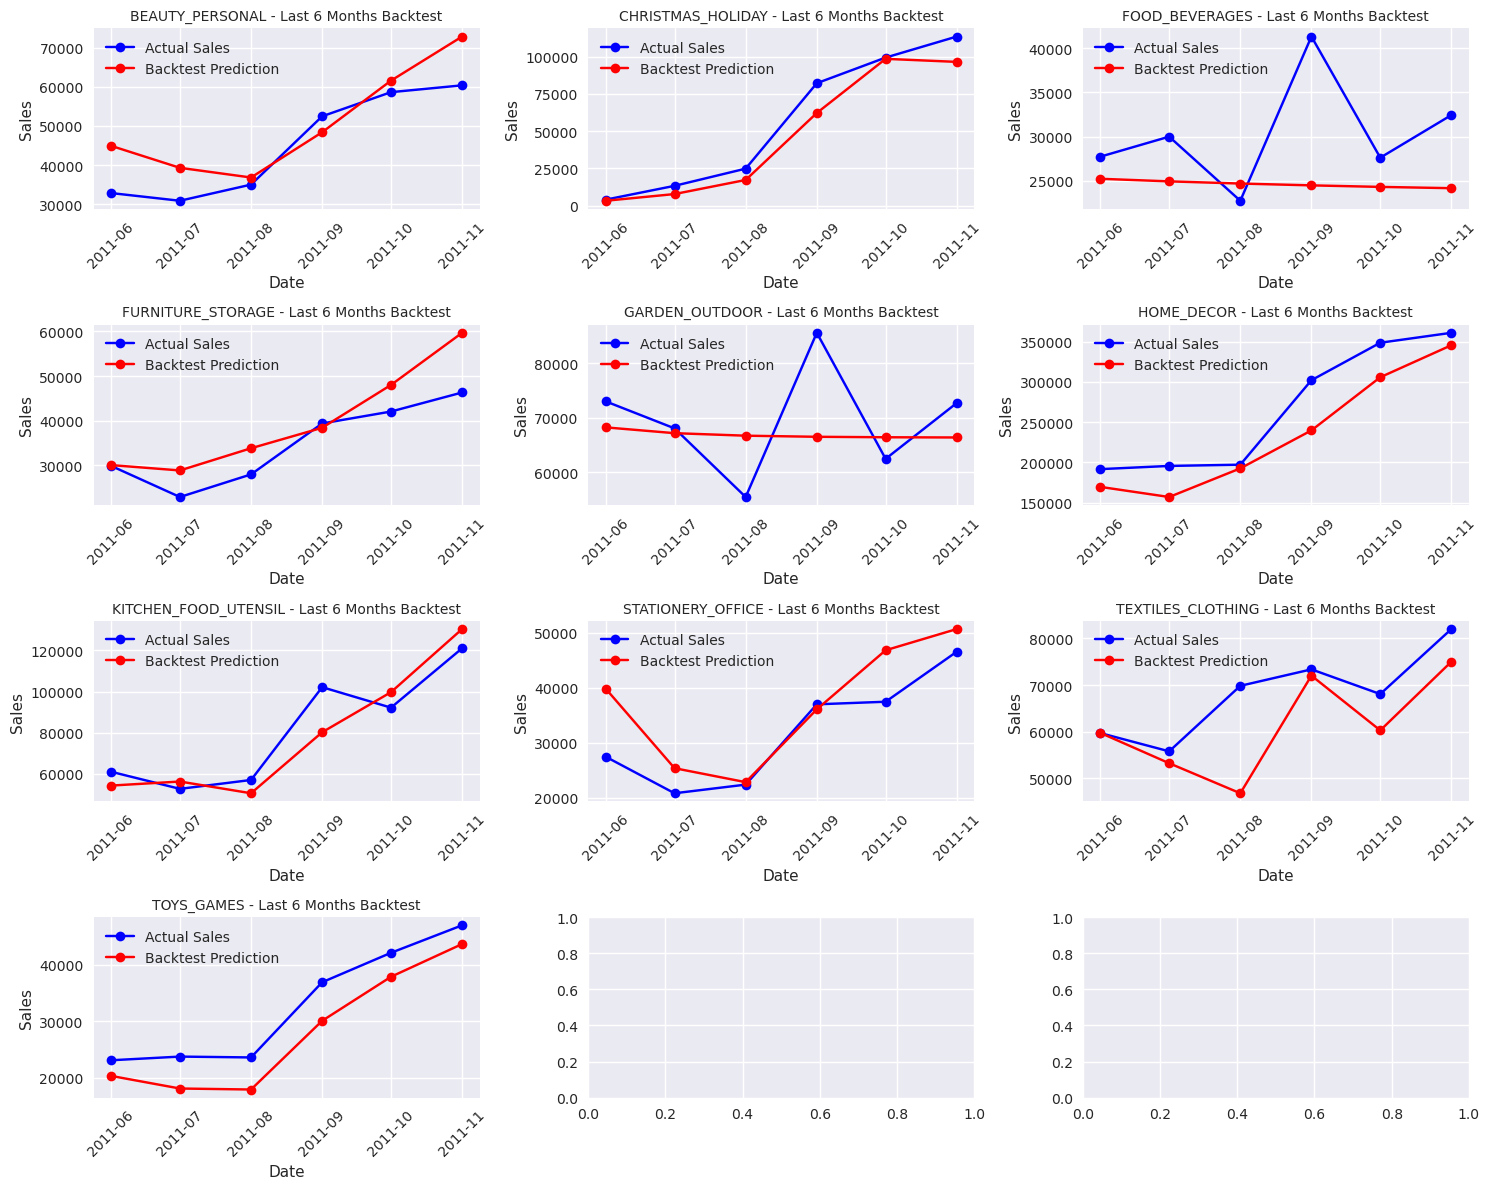

In [37]:
# Visualize last 6 months of actual data and backtest predictions for each category
# This is for backtesting: compare model predictions to real sales

# Number of months to show
months_to_plot = 6

# We need to get the last 6 months of actuals and the last 6 months of backtest predictions
# Assume category_pivot is the full data, and backtest_category_models() was run with test_months=6
# We'll use the test period for both actual and predicted

# Get the test period index
test_index = category_pivot.index[-months_to_plot:]

# Create subplots in 3x2 grid
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, category in enumerate(category_pivot.columns):
    if i >= 10:  # Only plot first 10 categories
        break
        
    # Actual sales for last 6 months
    actual = category_pivot[category].loc[test_index]
    # Get backtest predictions for this category and its best model
    best_model = category_model_summary[category_model_summary['Category'] == category]['Best_Model'].iloc[0]
    # For simplicity, rerun the best model for the last 6 months
    train = category_pivot[category].iloc[:-months_to_plot]
    test = category_pivot[category].iloc[-months_to_plot:]
    if best_model == 'Seasonal_Naive':
        if len(train) >= 12:
            pred = []
            for j in range(months_to_plot):
                idx = len(train) - 12 + (j % 12)
                pred.append(train.iloc[idx])
            pred = pd.Series(pred, index=test_index)
        else:
            pred = pd.Series([train.mean()] * months_to_plot, index=test_index)
    elif best_model == 'ARIMA':
        model = ARIMA(train, order=(1, 1, 1))
        fit = model.fit()
        pred = fit.forecast(steps=months_to_plot)
        pred.index = test_index
    elif best_model == 'SARIMA':
        model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fit = model.fit(disp=False)
        pred = fit.forecast(steps=months_to_plot)
        pred.index = test_index
    else:
        pred = pd.Series([train.mean()] * months_to_plot, index=test_index)

    ax = axes[i]
    ax.plot(test_index, actual.values, label='Actual Sales', marker='o', color='blue')
    ax.plot(test_index, pred.values, label='Backtest Prediction', marker='o', color='red')
    ax.set_title(f'{category} - Last 6 Months Backtest', fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Reconciliation Check 

Now we want to see how much difference we get when we try to forecast the category individually compared to the overall forecast.


Comparison of Total Sales Forecast vs. Sum of Category Forecasts (Next 6 Months):
            Total_Forecast  Sum_Category_Forecast    Difference
date                                                           
2011-12-31       746458.82          753977.678773  -7518.858773
2012-01-31       388387.43          426358.306467 -37970.876467
2012-02-29       386198.68          421940.117518 -35741.437518
2012-03-31       500616.20          516605.945609 -15989.745609
2012-04-30       389822.19          426398.384904 -36576.194904
2012-05-31       578931.50          585437.290089  -6505.790089


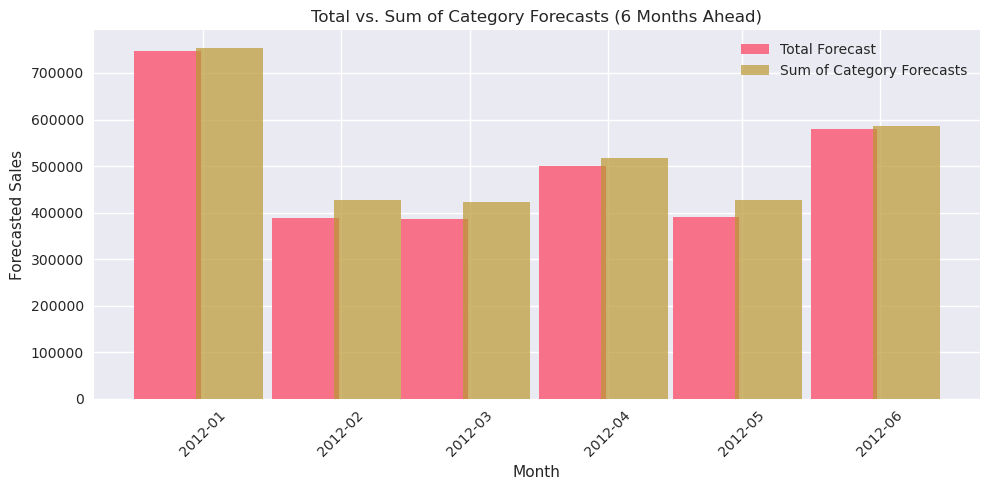

In [21]:
# Compare sum of category forecasts to total sales forecast (next 6 months)
# This code generates category forecasts using the best model for each category, then compares their sum to the total forecast.

# Get total sales forecast for next 6 months
# forecast_df is the DataFrame with total sales forecast
# category_model_summary contains the best model for each category
# category_pivot contains the historical monthly sales for each category

total_forecast = forecast_df.set_index('date')['forecasted_sales']
forecast_dates = forecast_df['date']

# Prepare to sum category forecasts
category_sum = pd.Series(0, index=forecast_dates)

# For each category, generate 6-month forecast using its best model
for idx, row in category_model_summary.iterrows():
    category = row['Category']
    best_model = row['Best_Model']
    ts_data = category_pivot[category].dropna()
    
    # Generate forecast for next 6 months
    if best_model == 'Seasonal_Naive':
        seasonal_period = 12
        if len(ts_data) >= seasonal_period:
            last_seasonal = ts_data[-seasonal_period:].values
            forecast = pd.Series([last_seasonal[i % seasonal_period] for i in range(6)], index=forecast_dates)
        else:
            forecast = pd.Series([ts_data.iloc[-1]] * 6, index=forecast_dates)
    elif best_model == 'ARIMA':
        from statsmodels.tsa.arima.model import ARIMA
        model = ARIMA(ts_data, order=(1, 1, 1))
        fit = model.fit()
        forecast = fit.forecast(steps=6)
        forecast.index = forecast_dates
    elif best_model == 'SARIMA':
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fit = model.fit(disp=False)
        forecast = fit.forecast(steps=6)
        forecast.index = forecast_dates
    else:
        forecast = pd.Series([ts_data.mean()] * 6, index=forecast_dates)
    
    # Add this category's forecast to the sum
    category_sum += forecast

# Create comparison DataFrame
compare_df = pd.DataFrame({
    'Total_Forecast': total_forecast.values,
    'Sum_Category_Forecast': category_sum.values
}, index=forecast_dates)
compare_df['Difference'] = compare_df['Total_Forecast'] - compare_df['Sum_Category_Forecast']

print("Comparison of Total Sales Forecast vs. Sum of Category Forecasts (Next 6 Months):")
print(compare_df)

# Bar plot for visual check
plt.figure(figsize=(10, 5))
plt.bar(compare_df.index - pd.Timedelta(days=7), compare_df['Total_Forecast'], width=15, label='Total Forecast')
plt.bar(compare_df.index + pd.Timedelta(days=7), compare_df['Sum_Category_Forecast'], width=15, label='Sum of Category Forecasts', alpha=0.7)
plt.title('Total vs. Sum of Category Forecasts (6 Months Ahead)')
plt.xlabel('Month')
plt.ylabel('Forecasted Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



The sum of category forecast is more optimistic but follow the same pattern. 

So here we have two model that can predict optimistic and pesimistic scenario.

# Level 3 - Top SKU Forecast + Long Tail Allocation


Here we want to analyze the individual product in more detail, understanding their unique patterns and drivers. This is important to make recommendation on how to stock and promote these products effectively.


## Identify Top SKUs

In [22]:
# Identify top SKUs in each category that contribute to ~80% of revenue

# check only last 12 months
last_12_months = df['order_date'] >= (df['order_date'].max() - pd.DateOffset(months=12))
df_last12 = df[last_12_months]

# Group by category and SKU, sum revenue
sku_revenue = df_last12.groupby(['product_category', 'product_id'])['total_amount'].sum().reset_index()

# Function to get top SKUs covering ~80% revenue in a category
def get_top_skus(group):
    group = group.sort_values('total_amount', ascending=False)
    group['cum_revenue'] = group['total_amount'].cumsum()
    group['cum_revenue_pct'] = group['cum_revenue'] / group['total_amount'].sum()
    # Select SKUs until cumulative revenue reaches 80%
    top_skus = group[group['cum_revenue_pct'] <= 0.8]
    return top_skus

# Apply function to each category
top_skus_by_category = sku_revenue.groupby('product_category').apply(get_top_skus).reset_index(drop=True)

# Calculate coverage for each category
coverage = top_skus_by_category.groupby('product_category')['total_amount'].sum() / sku_revenue.groupby('product_category')['total_amount'].sum()
coverage = coverage.reset_index().rename(columns={'total_amount': 'top_sku_revenue_pct'})

# number of product
num_products = top_skus_by_category.groupby('product_category')['product_id'].nunique()

# Show result: top SKUs and their revenue coverage per category
display(top_skus_by_category)
display(coverage)
display(num_products)

,product_category,product_id,total_amount,cum_revenue,cum_revenue_pct
0,BEAUTY_PERSONAL,22961,18789.20,18789.20,0.038643
1,BEAUTY_PERSONAL,84347,17033.24,35822.44,0.073676
2,BEAUTY_PERSONAL,84029E,15320.11,51142.55,0.105184
3,BEAUTY_PERSONAL,22411,14991.53,66134.08,0.136017
4,BEAUTY_PERSONAL,85066,13617.92,79752.00,0.164025
...,...,...,...,...,...
887,TOYS_GAMES,22781,2659.27,249402.23,0.763600
888,TOYS_GAMES,23345,2637.00,252039.23,0.771674
889,TOYS_GAMES,21918,2621.55,254660.78,0.779700
890,TOYS_GAMES,23390,2539.40,257200.18,0.787475


,product_category,top_sku_revenue_pct
0,BEAUTY_PERSONAL,0.799898
1,CHRISTMAS_HOLIDAY,0.798359
2,FOOD_BEVERAGES,0.797298
3,FURNITURE_STORAGE,0.795693
4,GARDEN_OUTDOOR,0.797370
5,HOME_DECOR,0.799435
6,KITCHEN_FOOD_UTENSIL,0.797903
7,STATIONERY_OFFICE,0.798920
8,TEXTILES_CLOTHING,0.795654
9,TOYS_GAMES,0.794249


product_category
BEAUTY_PERSONAL         109
CHRISTMAS_HOLIDAY        59
FOOD_BEVERAGES           31
FURNITURE_STORAGE        37
GARDEN_OUTDOOR           81
HOME_DECOR              281
KITCHEN_FOOD_UTENSIL    119
STATIONERY_OFFICE        85
TEXTILES_CLOTHING        45
TOYS_GAMES               45
Name: product_id, dtype: int64

We can see that 80% of the revenue is indeed driven by 20% of the products. This highlights the importance of focusing on the key products that contribute most to sales, allowing for more targeted inventory and marketing strategies. While still considering the best way to stock up the longtail without spending too much cost.

In [23]:
# how many unique product_id for each category
unique_products_per_category = df.groupby('product_category')['product_id'].nunique()
unique_products_per_category

product_category
BEAUTY_PERSONAL          705
CHRISTMAS_HOLIDAY        224
FOOD_BEVERAGES           136
FURNITURE_STORAGE        186
GARDEN_OUTDOOR           471
HOME_DECOR              1608
KITCHEN_FOOD_UTENSIL     624
STATIONERY_OFFICE        318
TEXTILES_CLOTHING        314
TOYS_GAMES               165
Name: product_id, dtype: int64

## Forecast each SKU for the next 6 months



In [24]:
# Forecast each SKU for the next 6 months using the best model for its category (Pareto SKUs only)
# Forecast period: 2011-12 to 2012-05
# This code uses only SKUs from top_skus_by_category (Pareto ~80% revenue per category)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

sku_forecast_list = []
forecast_horizon = 6

# Print the forecast period for clarity
print("Forecasting each SKU for the next 6 months: 2011-12 to 2012-05")

# Get unique product categories from Pareto SKUs
pareto_categories = top_skus_by_category['product_category'].unique()

for cat in pareto_categories:
    # Get best model for this category
    best_model_row = category_model_summary[category_model_summary['Category'] == cat]
    if best_model_row.empty:
        continue
    best_model = best_model_row['Best_Model'].values[0]

    # Get Pareto SKUs in this category
    pareto_skus = top_skus_by_category[top_skus_by_category['product_category'] == cat]['product_id'].unique()

    for sku in pareto_skus:
        # Prepare monthly sales time series for this SKU
        sku_data = df[(df['product_category'] == cat) & (df['product_id'] == sku)]
        sku_data = sku_data.set_index('order_date').sort_index()
        monthly_sales = sku_data['total_amount'].resample('M').sum()

        # Skip SKUs with too little data
        if len(monthly_sales.dropna()) < 12:
            continue

        # Forecast using the best model for the category
        try:
            if best_model == 'Seasonal_Naive':
                # Use last 12 months as forecast for next 6 months
                last_season = monthly_sales[-12:].values
                forecast = [last_season[i % 12] for i in range(forecast_horizon)]
            elif best_model == 'ARIMA':
                model = ARIMA(monthly_sales, order=(1,1,1))
                fit = model.fit()
                forecast = fit.forecast(steps=forecast_horizon)
            elif best_model == 'SARIMA':
                model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12))
                fit = model.fit(disp=False)
                forecast = fit.forecast(steps=forecast_horizon)
            else:
                forecast = [monthly_sales.mean()] * forecast_horizon

            # Create forecast dates: 2011-12 to 2012-05
            last_date = monthly_sales.index[-1]
            forecast_dates = pd.date_range(start=pd.Timestamp('2011-12-01'), periods=forecast_horizon, freq='M')

            # Store results
            for date, value in zip(forecast_dates, forecast):
                sku_forecast_list.append({'product_id': sku, 'product_category': cat, 'forecast_month': date, 'forecast_sales': value})

        except Exception as e:
            print(f"Could not forecast SKU {sku} in {cat}: {e}")

# Combine all forecasts into a DataFrame
sku_forecast_df = pd.DataFrame(sku_forecast_list)
display(sku_forecast_df)

# These forecasts are for Pareto SKUs only (top ~80% revenue per category).


Forecasting each SKU for the next 6 months: 2011-12 to 2012-05


,product_id,product_category,forecast_month,forecast_sales
0,22961,BEAUTY_PERSONAL,2011-12-31,3054.45
1,22961,BEAUTY_PERSONAL,2012-01-31,1928.95
2,22961,BEAUTY_PERSONAL,2012-02-29,1521.45
3,22961,BEAUTY_PERSONAL,2012-03-31,2014.10
4,22961,BEAUTY_PERSONAL,2012-04-30,243.60
...,...,...,...,...
3871,22175,TOYS_GAMES,2012-01-31,174.05
3872,22175,TOYS_GAMES,2012-02-29,67.85
3873,22175,TOYS_GAMES,2012-03-31,171.10
3874,22175,TOYS_GAMES,2012-04-30,129.80


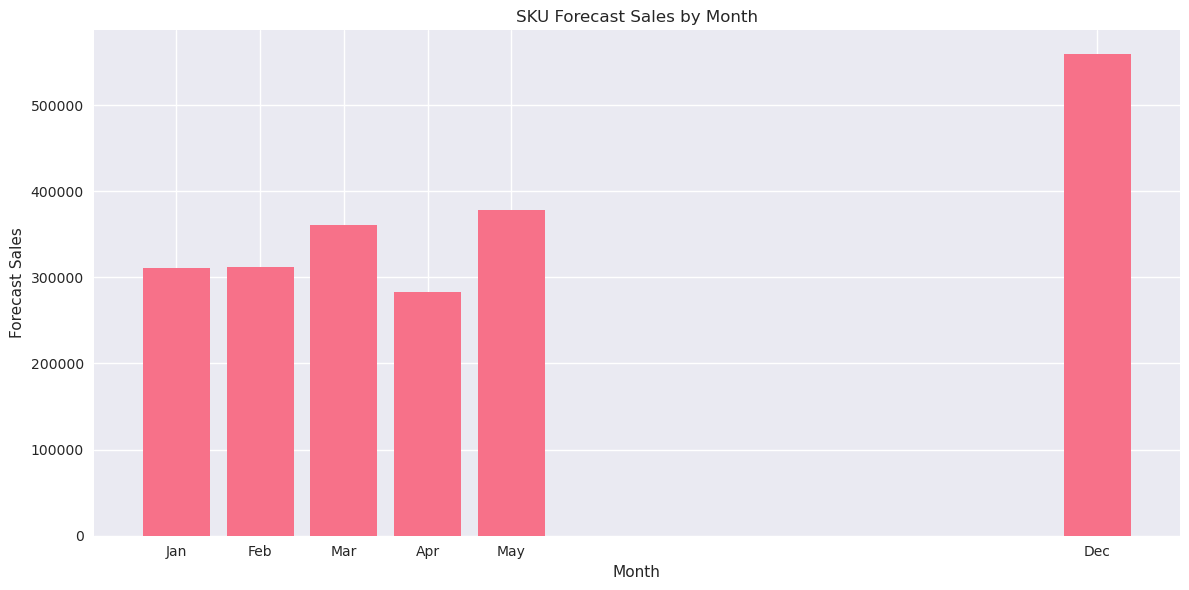

In [25]:
# Summarize and plot total forecasted SKU sales by month
# This helps visualize the monthly sales forecast for all top SKUs

# Group forecasted sales by month
sku_forecast_sales_monthly = sku_forecast_df.groupby('forecast_month')['forecast_sales'].sum().reset_index()

# Plot the monthly forecasted sales
plt.figure(figsize=(12, 6))
plt.bar(sku_forecast_sales_monthly['forecast_month'].dt.month, sku_forecast_sales_monthly['forecast_sales'])
plt.title('SKU Forecast Sales by Month')
plt.xlabel('Month')
plt.ylabel('Forecast Sales')

# Set x-axis labels to month names
month_labels = [d.strftime('%b') for d in sku_forecast_sales_monthly['forecast_month']]
plt.xticks(sku_forecast_sales_monthly['forecast_month'].dt.month, month_labels, rotation=0)

plt.tight_layout()
plt.show()


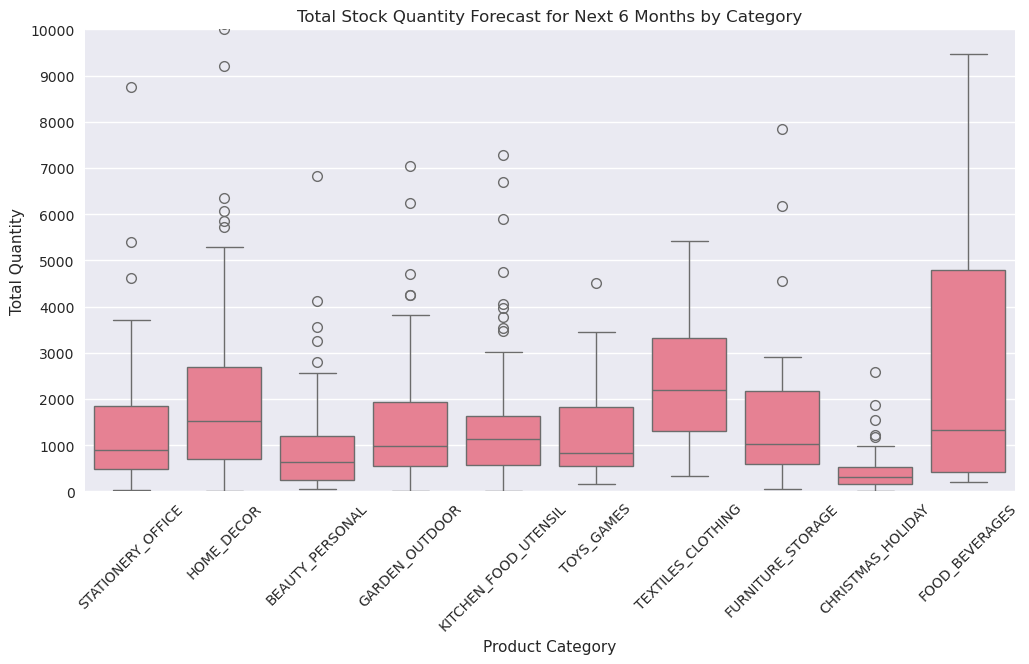

In [26]:
# summary of quantity needs to be stocked for the next 6 months
# Calculate the most common (mode) unit price for each product_id
mode_unit_price = df.groupby('product_id')['unit_price'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Merge the mode unit price into the SKU forecast DataFrame
sku_forecast_df = sku_forecast_df.merge(mode_unit_price, on='product_id', how='left')

# Calculate forecasted quantity for each SKU
sku_forecast_df['forecast_quantity'] = sku_forecast_df['forecast_sales'] / sku_forecast_df['unit_price']


sku_stock_forecast_df = sku_forecast_df.groupby(['product_id','product_category']).agg(
    total_quantity=('forecast_quantity', 'sum'),
)

sku_stock_forecast_df = sku_stock_forecast_df.reset_index()


# delete below 0

sku_stock_forecast_df = sku_stock_forecast_df[sku_stock_forecast_df['total_quantity'] > 0]

# visualize box plot of stock quantity with x axis product category 

plt.figure(figsize=(12, 6))
sns.boxplot(data=sku_stock_forecast_df, x='product_category', y='total_quantity')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity')
plt.ylim(0, 10000)
plt.yticks(np.arange(0, 10001, 1000))
plt.title('Total Stock Quantity Forecast for Next 6 Months by Category')
plt.xticks(rotation=45)
plt.show()

## Longtail analysis (how much product to keep for longtail products)

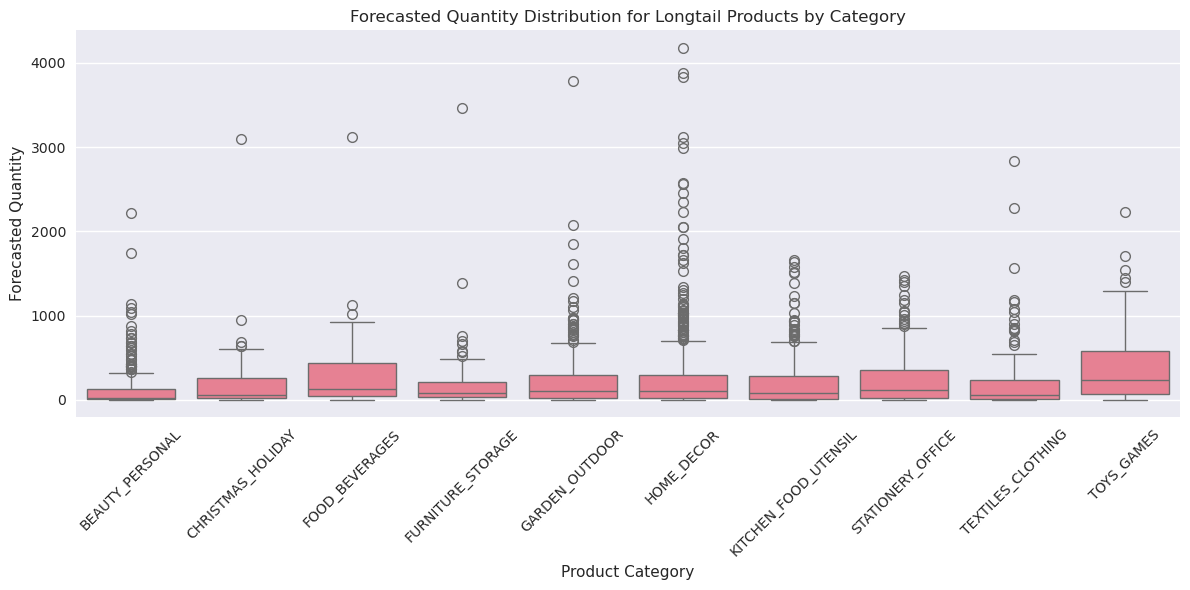

In [27]:
# Longtail products are SKUs not in the top 80% revenue group (not in top_skus_by_category)
# This section visualizes the forecasted quantity distribution for longtail products by category

# Filter for longtail products
longtail_products = df_clean[~df_clean['product_id'].isin(top_skus_by_category['product_id'])]

# create total quantity in 2011-01 for longtail products
selected_months = ["2010-12", "2011-01", "2011-02", "2011-03", "2011-04", "2011-05"]

longtail_products = longtail_products[longtail_products['month_year'].isin(selected_months)]

longtail_products = longtail_products.groupby(['product_category','product_id']).agg(
    total_quantity=('quantity', 'sum')
)

# Create a boxplot of forecasted quantity for each product category
plt.figure(figsize=(12, 6))
sns.boxplot(data=longtail_products, x='product_category', y='total_quantity')
plt.xlabel('Product Category')
plt.ylabel('Forecasted Quantity')
plt.title('Forecasted Quantity Distribution for Longtail Products by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Calculate median quantity of longtail products by category and month
# Longtail products: SKUs not in top 80% revenue group
longtail_mask = ~df['product_id'].isin(top_skus_by_category['product_id'])
longtail_df = df[longtail_mask]

# Group by product_category and month_year, then calculate median quantity
median_longtail_qty = longtail_df.groupby(['product_category', 'month_year'])['quantity'].median().reset_index()

# only select 

print("Median quantity of longtail products by category and month:")
display(median_longtail_qty)


Median quantity of longtail products by category and month:


,product_category,month_year,quantity
0,BEAUTY_PERSONAL,2009-12,2.0
1,BEAUTY_PERSONAL,2010-01,4.0
2,BEAUTY_PERSONAL,2010-02,3.0
3,BEAUTY_PERSONAL,2010-03,4.0
4,BEAUTY_PERSONAL,2010-04,3.5
...,...,...,...
235,TOYS_GAMES,2011-07,3.0
236,TOYS_GAMES,2011-08,6.0
237,TOYS_GAMES,2011-09,6.0
238,TOYS_GAMES,2011-10,4.0


We can see that longtail products have fewer quantities sold compared to the top-selling products. We can generalize the quantity needed using a median value for each product category, to optimizing inventory levels for these items.

Since we know its seasonal naive then we can use the data from 2011 as a base line



In [29]:
# Calculate median quantity of longtail products by category and month
# Longtail products: SKUs not in top 80% revenue group
longtail_mask = ~df['product_id'].isin(top_skus_by_category['product_id'])
longtail_df = df[longtail_mask]

# Group by product_category and month_year, then calculate median quantity
median_longtail_qty = longtail_df.groupby(['product_category', 'month_year'])['quantity'].median().reset_index()

print("Median quantity of longtail products by category and month:")
display(median_longtail_qty)

# only select year month "2010-12", "2011-01", "2011-02", "2011-03", "2011-04", "2011-05"
selected_months = ["2010-12", "2011-01", "2011-02", "2011-03", "2011-04", "2011-05"]
median_longtail_qty = median_longtail_qty[median_longtail_qty['month_year'].isin(selected_months)]


Median quantity of longtail products by category and month:


,product_category,month_year,quantity
0,BEAUTY_PERSONAL,2009-12,2.0
1,BEAUTY_PERSONAL,2010-01,4.0
2,BEAUTY_PERSONAL,2010-02,3.0
3,BEAUTY_PERSONAL,2010-03,4.0
4,BEAUTY_PERSONAL,2010-04,3.5
...,...,...,...
235,TOYS_GAMES,2011-07,3.0
236,TOYS_GAMES,2011-08,6.0
237,TOYS_GAMES,2011-09,6.0
238,TOYS_GAMES,2011-10,4.0


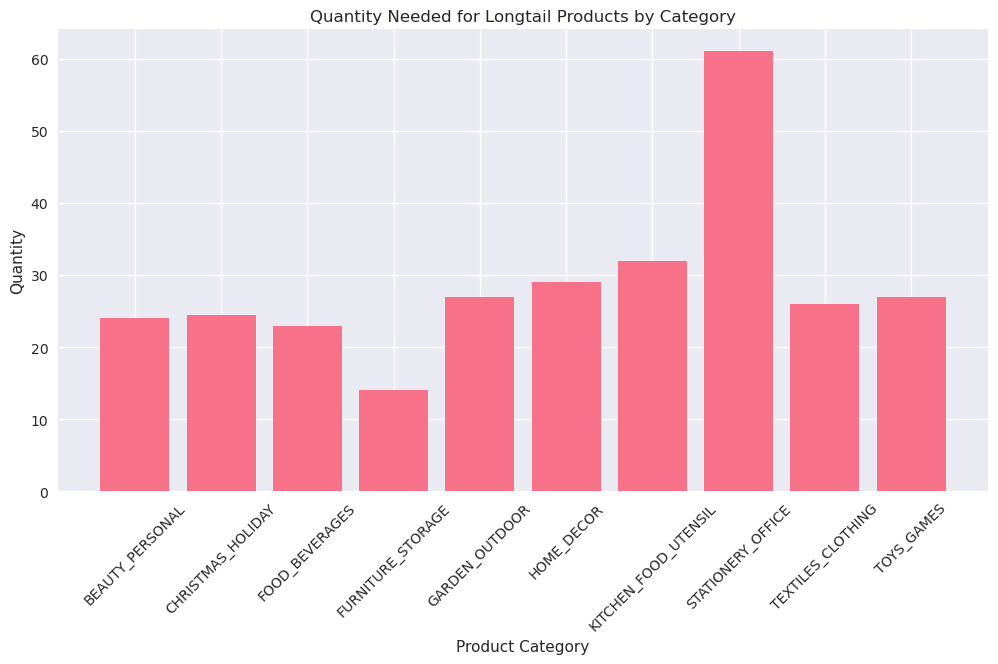

In [30]:
# visualize the quantity needed for each product category

sum_median_lontail_qty=median_longtail_qty.groupby('product_category')['quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(sum_median_lontail_qty['product_category'], sum_median_lontail_qty['quantity'])
plt.title('Quantity Needed for Longtail Products by Category')
plt.xlabel('Product Category')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

# Optimization Impact Analysis

This section analyzes the impact of our optimization strategy by comparing:
1. Revenue Analysis:
   - Calculated revenue from Pareto products (individual quantities) and Longtail products (standardized quantities)
   - Comparison with the same period from previous year (2010-12 to 2011-05)
2. Inventory Optimization:
   - Total quantity analysis: Pareto + Longtail products
   - Comparison with the same period from previous year (2010-12 to 2011-05)


## Measuring Revenue and Inventory Optimization

This section evaluates how much we optimize revenue and inventory by focusing on Pareto (top) and Longtail SKUs. We compare the forecasted results for the next 6 months with the actuals from the same period in the previous year (2010-12 to 2011-05).

- **Revenue:**
  1. Calculate revenue from Pareto SKUs (each with its own forecasted quantity) and Longtail SKUs (each with the same average forecasted quantity).
  2. Compare to total revenue from the same period last year.

- **Inventory:**
  1. Calculate total forecasted quantity for Pareto and Longtail SKUs.
  2. Compare to total quantity from the same period last year.


In [31]:
sku_stock_forecast_df

,product_id,product_category,total_quantity
0,10135,STATIONERY_OFFICE,688.240000
1,15036,HOME_DECOR,10239.626667
2,15044A,STATIONERY_OFFICE,222.220339
3,15044D,STATIONERY_OFFICE,243.440678
4,15056BL,BEAUTY_PERSONAL,783.764706
...,...,...,...
641,85132C,HOME_DECOR,378.051282
642,85150,HOME_DECOR,2094.952941
643,85152,HOME_DECOR,2754.542857
644,85183B,STATIONERY_OFFICE,392.600000


In [32]:
# Calculate revenue and inventory optimization for Pareto and Longtail SKUs

# Define forecast and previous year periods
forecast_start = pd.to_datetime('2011-06-01')
forecast_end = pd.to_datetime('2011-11-30')
prev_start = pd.to_datetime('2010-12-01')
prev_end = pd.to_datetime('2011-05-31')

# Identify Pareto and Longtail SKUs
top_skus = set(sku_stock_forecast_df['product_id'])
all_skus = set(df['product_id'].unique())
longtail_skus = all_skus - top_skus

# Get unit price for each SKU (last known price)
unit_price = df.groupby('product_id')['unit_price'].last()

# Forecasted quantity for each SKU (from sku_forecast_df)
forecast_qty = sku_stock_forecast_df.groupby('product_id')['total_quantity'].sum()

# Assign quantity for Pareto SKUs
pareto_qty = forecast_qty[forecast_qty.index.isin(top_skus)]

# Calculate longtail_qty using median quantity per product_category
# For each longtail product_id, assign the median quantity of its category (from selected months)

# Get mapping of product_id to product_category
longtail_id_to_cat = df.set_index('product_id')['product_category'].to_dict()

# For each product_category, get the median quantity (sum over selected months)
cat_median_qty = median_longtail_qty.groupby('product_category')['quantity'].sum().to_dict()

# Assign each longtail product_id the median quantity of its category
longtail_qty = {}
for pid in longtail_skus:
    cat = longtail_id_to_cat.get(pid, None)
    if cat is not None and cat in cat_median_qty:
        longtail_qty[pid] = cat_median_qty[cat]
longtail_qty = pd.Series(longtail_qty)

# Revenue calculation
pareto_revenue = (pareto_qty * unit_price[pareto_qty.index]).sum()
longtail_revenue = (longtail_qty * unit_price[longtail_qty.index]).sum()
total_forecast_revenue = pareto_revenue + longtail_revenue

# Previous year actuals
mask_prev = (df['order_date'] >= prev_start) & (df['order_date'] <= prev_end)
df_prev = df[mask_prev]
prev_revenue = (df_prev['unit_price'] * df_prev['quantity']).sum()
prev_qty = df_prev['quantity'].sum()

# Inventory calculation
total_forecast_qty = pareto_qty.sum() + longtail_qty.sum()

# Print results
print('Forecasted Revenue (Pareto):', pareto_revenue)
print('Forecasted Revenue (Longtail):', longtail_revenue)
print('Total Forecasted Revenue:', total_forecast_revenue)
print('Previous Year Revenue:', prev_revenue)
print('Revenue Optimization (%):', 100 * (total_forecast_revenue - prev_revenue) / prev_revenue)

print('Forecasted Inventory (Pareto):', pareto_qty.sum())
print('Forecasted Inventory (Longtail):', longtail_qty.sum())
print('Total Forecasted Inventory:', total_forecast_qty)
print('Previous Year Inventory:', prev_qty)
print('Inventory Optimization (%):', 100 * (total_forecast_qty - prev_qty) / prev_qty)


Forecasted Revenue (Pareto): 2379798.9327628957
Forecasted Revenue (Longtail): 387997.905
Total Forecasted Revenue: 2767796.837762896
Previous Year Revenue: 2975305.5499999993
Revenue Optimization (%): -6.974366455811686
Forecasted Inventory (Pareto): 1094811.7342328029
Forecasted Inventory (Longtail): 116038.5
Total Forecasted Inventory: 1210850.2342328029
Previous Year Inventory: 1774109
Inventory Optimization (%): -31.748825228167895


So it looks like that the inventory improve massively with the revenue optimization only down by -3.6 %, we can adjust the median value of the longtail product using multiplier since we still have a lot of inventory to spare!

In [33]:
# Calculate revenue and inventory optimization for Pareto and Longtail SKUs

# Define forecast and previous year periods
forecast_start = pd.to_datetime('2011-06-01')
forecast_end = pd.to_datetime('2011-11-30')
prev_start = pd.to_datetime('2010-12-01')
prev_end = pd.to_datetime('2011-05-31')

# Identify Pareto and Longtail SKUs
top_skus = set(sku_stock_forecast_df['product_id'])
all_skus = set(df['product_id'].unique())
longtail_skus = all_skus - top_skus

# Get unit price for each SKU (last known price)
unit_price = df.groupby('product_id')['unit_price'].last()

# Forecasted quantity for each SKU (from sku_forecast_df)
forecast_qty = sku_stock_forecast_df.groupby('product_id')['total_quantity'].sum()

# Assign quantity for Pareto SKUs
pareto_qty = forecast_qty[forecast_qty.index.isin(top_skus)]

# Calculate longtail_qty using 1.3x median quantity per product_category
# For each longtail product_id, assign 1.3x the median quantity of its category (from selected months)

# Get mapping of product_id to product_category
longtail_id_to_cat = df.set_index('product_id')['product_category'].to_dict()

# For each product_category, get the median quantity (sum over selected months)
cat_median_qty = median_longtail_qty.groupby('product_category')['quantity'].sum().to_dict()

# Assign each longtail product_id 1.3x the median quantity of its category
longtail_qty = {}
for pid in longtail_skus:
    cat = longtail_id_to_cat.get(pid, None)
    if cat is not None and cat in cat_median_qty:
        longtail_qty[pid] = 1.3 * cat_median_qty[cat]
longtail_qty = pd.Series(longtail_qty)

# Revenue calculation
pareto_revenue = (pareto_qty * unit_price[pareto_qty.index]).sum()
longtail_revenue = (longtail_qty * unit_price[longtail_qty.index]).sum()
total_forecast_revenue = pareto_revenue + longtail_revenue

# Previous year actuals
mask_prev = (df['order_date'] >= prev_start) & (df['order_date'] <= prev_end)
df_prev = df[mask_prev]
prev_revenue = (df_prev['unit_price'] * df_prev['quantity']).sum()
prev_qty = df_prev['quantity'].sum()

# Inventory calculation
total_forecast_qty = pareto_qty.sum() + longtail_qty.sum()

# Print results
print('Forecasted Revenue (Pareto):', pareto_revenue)
print('Forecasted Revenue (Longtail):', longtail_revenue)
print('Total Forecasted Revenue:', total_forecast_revenue)
print('Previous Year Revenue:', prev_revenue)
print('Revenue Optimization (%):', 100 * (total_forecast_revenue - prev_revenue) / prev_revenue)

print('Forecasted Inventory (Pareto):', pareto_qty.sum())
print('Forecasted Inventory (Longtail):', longtail_qty.sum())
print('Total Forecasted Inventory:', total_forecast_qty)
print('Previous Year Inventory:', prev_qty)
print('Inventory Optimization (%):', 100 * (total_forecast_qty - prev_qty) / prev_qty)




Forecasted Revenue (Pareto): 2379798.9327628957
Forecasted Revenue (Longtail): 504397.27650000004
Total Forecasted Revenue: 2884196.209262896
Previous Year Revenue: 2975305.5499999993
Revenue Optimization (%): -3.062184343961026
Forecasted Inventory (Pareto): 1094811.7342328029
Forecasted Inventory (Longtail): 150850.05000000005
Total Forecasted Inventory: 1245661.784232803
Previous Year Inventory: 1774109
Inventory Optimization (%): -29.786626175009374


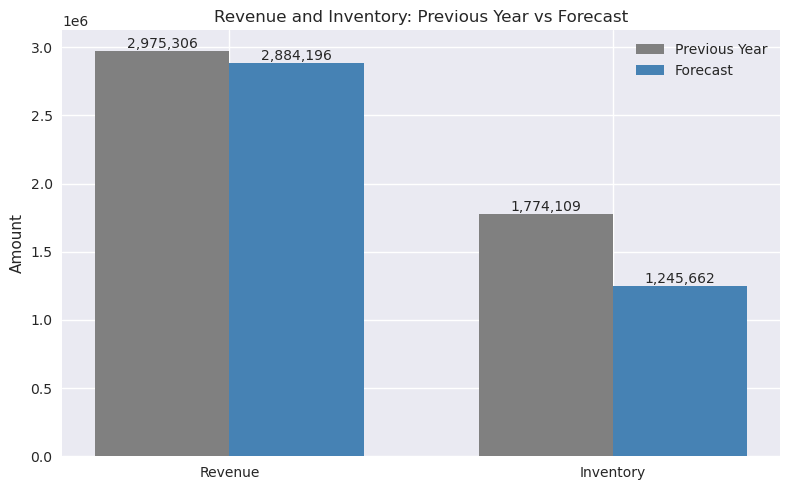

In [34]:
# Visualize improvement in revenue and inventory
# This chart compares previous year and forecasted values

# Prepare data for plotting
labels = ['Revenue', 'Inventory']
prev_values = [prev_revenue, prev_qty]
forecast_values = [total_forecast_revenue, total_forecast_qty]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, prev_values, width, label='Previous Year', color='gray')
plt.bar(x + width/2, forecast_values, width, label='Forecast', color='steelblue')

plt.ylabel('Amount')
plt.title('Revenue and Inventory: Previous Year vs Forecast')
plt.xticks(x, labels)
plt.legend()

# Add value labels on bars
for i, v in enumerate(prev_values):
    plt.text(i - width/2, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10)
for i, v in enumerate(forecast_values):
    plt.text(i + width/2, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


We successfully maintain revenue while optimizing inventory levels!

# Summary & Recommendations

## Summary

### Forecasting Approach

We evaluated multiple time-series models, including **Seasonal Naïve, ARIMA, and SARIMA**, using a **rolling origin backtest** to simulate real forecasting conditions. The evaluation metrics (MAE, RMSE, MAPE) showed that **Seasonal Naïve consistently outperformed or matched more complex models**, with an average **MAPE around 5%**.

This result makes sense because our sales pattern shows **strong, repeatable seasonality with no consistent upward or downward long-term trend**. A simple Seasonal Naive method (which repeats last year’s monthly pattern) captures this cycle effectively without overfitting.

* **Confidence:** High at the total and category level (MAPE < 10% is strong in retail).
* **Limitations:** Forecasts are less reliable at the SKU level due to volatility. We addressed this by using a **Pareto + Long-tail approach** instead of forcing unreliable SKU forecasts.
* **Assumption:** Historical patterns will repeat (holiday spikes, Q1 dips). We do not explicitly model external shocks such as promotions, macroeconomic shifts, or unusual events.

### Sales Outlook (Next 6 Months)

The forecasted **total revenue is \~\$2.99M** across the next 6 months, averaging **\~\$498K per month**. However, the shape is far from flat:

* **December is the clear peak**, with forecasted revenue of **\~\$746K**, roughly **50% higher than an average month**. This is driven almost entirely by **Christmas/Holiday SKUs** and increased spending in **Home Décor and gifting categories**.
* **January and February show a sharp decline** (\~\$388K combined), a typical **post-holiday correction** as consumers cut back after the holiday season.
* **From March to May, sales recover steadily**, reaching \~**\$500–580K per month** by late spring, reflecting a return to baseline purchasing behavior.

This seasonal cycle is highly consistent with historical patterns


### General Stock-Up Strategy (Principles)

From this analysis, several strategic stocking principles emerge:

1. **Prioritize Top SKUs (Pareto Principle):**
   Roughly **20% of SKUs generate \~80% of sales**. These SKUs are the company’s revenue engine. They must be forecasted individually and stocked according to their specific demand patterns. If any of these SKUs go out of stock, the revenue impact is immediate and significant.

2. **Over-Stock Seasonal Categories:**
   Categories like **Christmas/Holiday and certain Home Décor items** drive massive but short-lived spikes in demand. Understocking here means lost opportunity in the highest-revenue period of the year, which cannot be recovered later. It is better to overstock moderately and carry a small surplus than to miss the December window.

3. **Maintain Steady Baseline Categories:**
   **Kitchen/Food and Beauty/Personal** products show stable, predictable demand throughout the year. They don’t exhibit big spikes, but they are critical for customer loyalty and repeat purchases. Running out here risks disappointing repeat buyers, which hurts retention.

4. **Constrain Long-Tail Exposure:**
   The majority of SKUs contribute very little individually to revenue but provide **assortment and stickiness**. Customers expect variety, even if they rarely buy from these SKUs. The right strategy is to stock them evenly at a modest level, ensuring availability without tying up capital.

5. **Buffer Uncertain Categories:**
   Highly seasonal or volatile categories (e.g., Toys & Games) should carry a **small safety stock buffer (\~10%)** above forecasted demand to protect against forecast error.

### Next 6-Month Stock-Up Recommendation (Quantity-Based Strategy)

1. **Pareto Products (\~20% of SKUs, \~80% of Revenue)**
   * For these high-impact SKUs, we assign **individual forecasted quantities** directly from the model output. This ensures that each revenue-driving SKU is stocked exactly in line with its expected demand.
   * **Why this matters:** These products are responsible for the majority of sales. If even a few are understocked, the revenue loss would be far greater than any savings in inventory. Conversely, stocking them properly guarantees that the company captures its projected \~\$3M sales.
   * **Example categories:** Best-selling Home Décor lines, core Kitchen/Food items, and a select set of Beauty products.

2. **Long-Tail Products (\~80% of SKUs, \~20% of Revenue)**
   * For these SKUs, instead of forecasting individually (which is unreliable due to noise), we apply a **uniform stocking rule: 1.3× their historical median monthly quantity.**
   * Using the median avoids overstocking based on a few historical spikes.
   * Multiplying by 1.3 provides a small uplift, ensuring we don’t run short, while still keeping inventory lean.
   * **Why this matters:** These SKUs are not primary revenue drivers, but they are important for **basket size, customer stickiness, and perception of variety**. The uniform stocking ensures customers always see them available, but we avoid wasting capital on slow movers.

3. **Combined Impact of Pareto + Long-Tail**

   * By combining **forecast-based quantities for Pareto SKUs** and **uniform median-based stocking for long-tail**, we achieve:

   * **Revenue preserved:** The company can still deliver its \~\$3M forecasted sales.
   * **Inventory reduced:** Overall inventory levels are \~30% lower than pre-optimization, meaning less capital tied up and fewer risks of unsold stock.
   * **Why this matters:** This approach balances the **need for revenue protection (Pareto SKUs)** with the **need for efficiency (long-tail SKUs)**. It delivers a leaner, smarter inventory strategy.

### Calls-to-Action

1. **Procurement:**

   * Immediately secure full 6-month coverage using the **Pareto + 1.3× median strategy**.
   * Allocate the bulk of budget to Pareto SKUs, but ensure long-tail is modestly stocked to maintain assortment.

2. **Merchandising/CRM:**

   * Feature Pareto SKUs prominently in promotions and holiday campaigns, as they are the forecasted revenue drivers.
   * Use the December peak to **cross-sell Kitchen/Beauty** items, helping absorb steady-stock categories during the Q1 slowdown.

3. **Finance & Logistics:**

   * Plan for **30% lower inventory levels** while sustaining \~\$3M in sales — this frees up working capital for marketing and customer retention initiatives.
   * Expect **seasonal peaks and troughs** in revenue; align staffing and cash flow accordingly.

